# Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---


# Initialization

In [85]:
import cv2
import glob
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
import numpy as np

%matplotlib inline

# 1: Camera Calibration using chessboard images

In [86]:
def calibrate_camera(imgs, nx = 9, ny = 6):

    # Arrays to store object points and image points from all the images.
    objpoints = [] # 3d points in real world space
    imgpoints = [] # 2d points in image plane.

    # Prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(8,4,0)
    objp = np.zeros((nx * ny, 3), np.float32)
    objp[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1, 2) # x, y coordinates

    for fname in imgs:    
        # read each image
        img = cv2.imread(fname)
        # convert image to grayscale
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        #plt.imshow(img)

        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)

        # If corners are found, add object points, image points
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)

        ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
        
    return ret, mtx, dist, rvecs, tvecs
        
# Make a list of calibration images
imgs = glob.glob('./camera_cal/calibration*.jpg')

ret, mtx, dist, rvecs, tvecs = calibrate_camera(imgs)

# 2: Apply a distortion correction to raw images.

Text(0.5,1,'Undistorted Image')

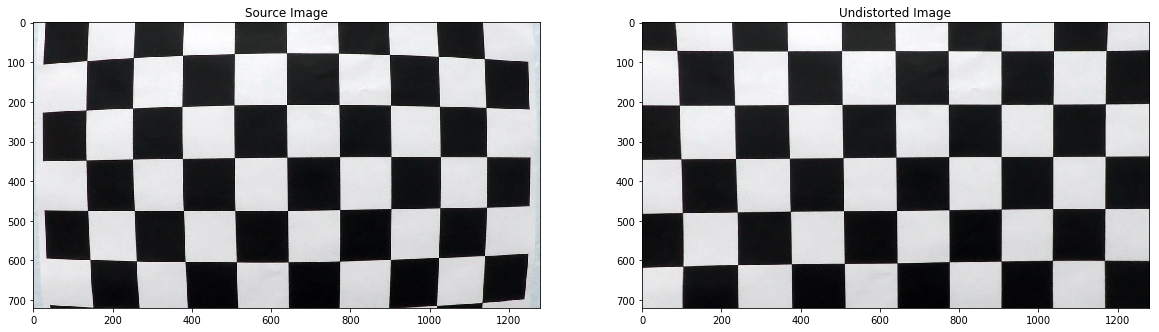

In [87]:
# Read an example image to apply distortion correction
img = cv2.imread('./camera_cal/calibration1.jpg')

undistorted_img = cv2.undistort(img, mtx, dist, None, mtx)

f, axarr = plt.subplots(1, 2, figsize=(20, 20))
axarr[0].imshow(img)
axarr[0].set_title('Source Image')
axarr[1].imshow(undistorted_img)
axarr[1].set_title('Undistorted Image')

# 3- Use color transforms, gradients, etc., to create a thresholded binary image.

Text(0.5,1,'RGB Undistorted Image')

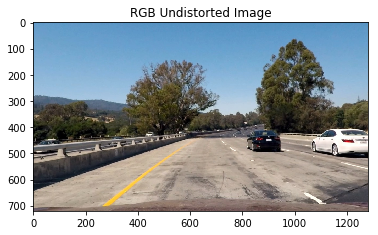

In [88]:
# Reading an example picture
original_img = cv2.imread('./test_images/test1.jpg')
# Converting to RGB scale
RGB_img = cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB)
# undistord the image with the informations that we calculated 
# in the previous section
RGB_undistorderd_img = cv2.undistort(RGB_img, mtx, dist, None, mtx)
plt.imshow(RGB_undistorderd_img)
plt.title('RGB Undistorted Image')

### 3-1:Directional Gradient

Text(0.5,1,'Gradient in Y')

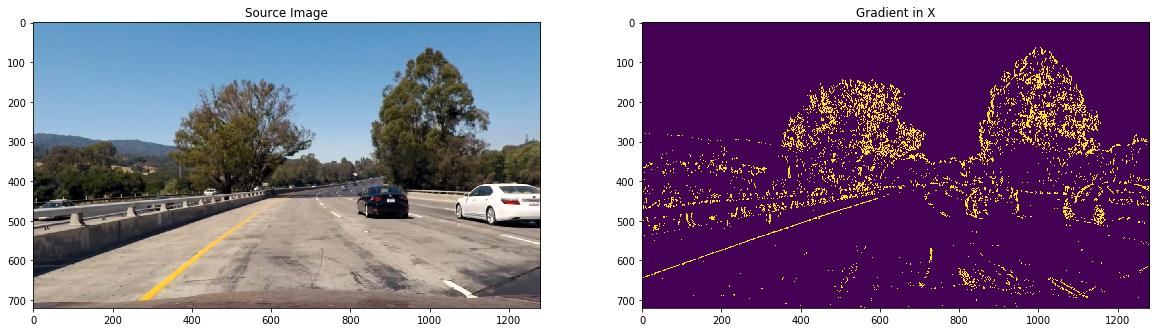

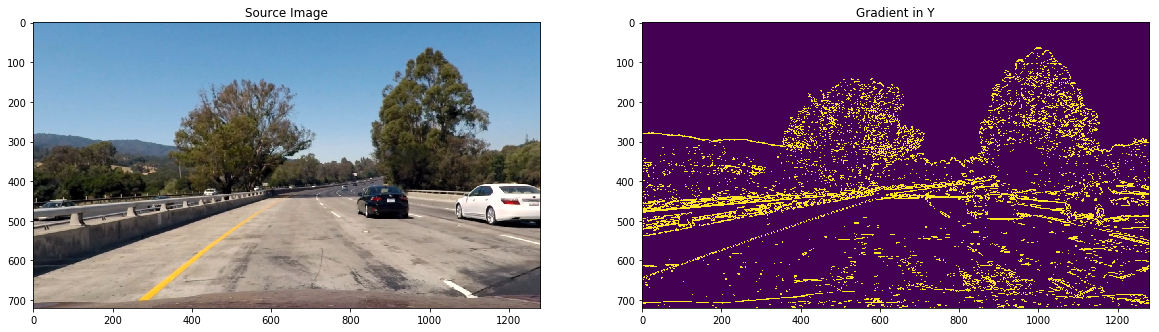

In [89]:
def abs_sobel_thresh(img, orient = 'x', sobel_kernel = 3, thresh = (0, 255)):

    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    # Apply x or y gradient with the OpenCV Sobel() function
    # and take the absolute value
    if orient == 'x':
        directional_sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0, sobel_kernel)
    if orient == 'y':
        directional_sobel = cv2.Sobel(gray, cv2.CV_64F, 0, 1, sobel_kernel)
        
    # Take the absolute value of the gradient or derivative
    abs_sobel = np.absolute(directional_sobel)
    # Scale to 8 bit integer (0-255)
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Apply the threshold (the inclusive thresholding "<=, >=" would work too)
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel > thresh[0]) & (scaled_sobel < thresh[1])] = 1

    return binary_output


# computethe gradient in X
gradient_x_binary = abs_sobel_thresh(RGB_undistorderd_img, orient = 'x', sobel_kernel = 15, thresh = (20, 100))

# plot
f, axarr = plt.subplots(1, 2, figsize=(20, 20))
axarr[0].imshow(RGB_undistorderd_img)
axarr[0].set_title('Source Image')
axarr[1].imshow(gradient_x_binary)
axarr[1].set_title('Gradient in X')

# computethe gradient in Y
gradient_y_binary = abs_sobel_thresh(RGB_undistorderd_img, orient = 'y', sobel_kernel = 15, thresh = (20, 100))

# plot
f, axarr = plt.subplots(1, 2, figsize=(20, 20))
axarr[0].imshow(RGB_undistorderd_img)
axarr[0].set_title('Source Image')
axarr[1].imshow(gradient_y_binary)
axarr[1].set_title('Gradient in Y')

### 3-2: Gradient magnitude 

Text(0.5,1,'Magnitude Gradient')

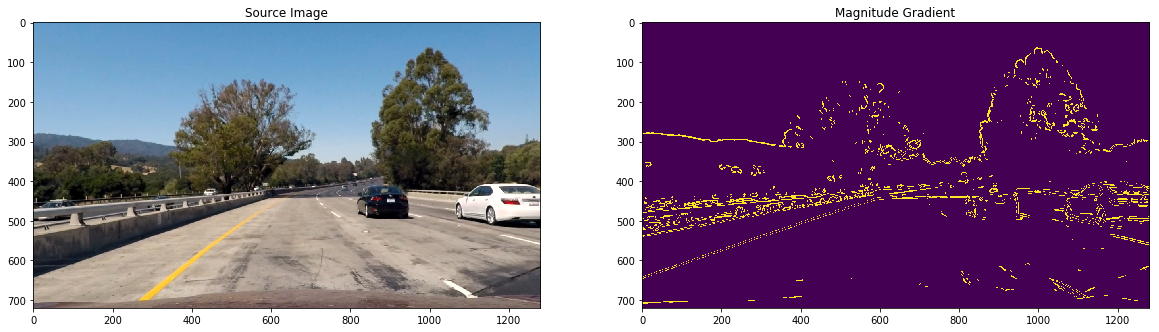

In [90]:
def mag_thres(img, sobel_kernel = 3, thresh = (0, 255)):
    
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Take the gradient in x and y seperately
    sobel_x = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize = sobel_kernel)
    sobel_y = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize = sobel_kernel)
    # Calculate the gradient magnitude
    abs_sobel = np.sqrt(np.power(sobel_x, 2) + np.power(sobel_y, 2))
    # Scale to 8 bit (0-255)
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel)) 
    # Applying the threshold
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel > thresh[0]) & (scaled_sobel < thresh[1])] = 1

    # Return the binary image
    return binary_output

# compute the gradient magnitude
magnitude_gradient_binary = mag_thres(RGB_undistorderd_img, sobel_kernel = 15, thresh= (60, 100))

# plot
f, axarr = plt.subplots(1, 2, figsize=(20, 20))
axarr[0].imshow(RGB_undistorderd_img)
axarr[0].set_title('Source Image')
axarr[1].imshow(magnitude_gradient_binary)
axarr[1].set_title('Magnitude Gradient')

#### 3-3: Gradient direction 

Text(0.5,1,'Gradient Direction')

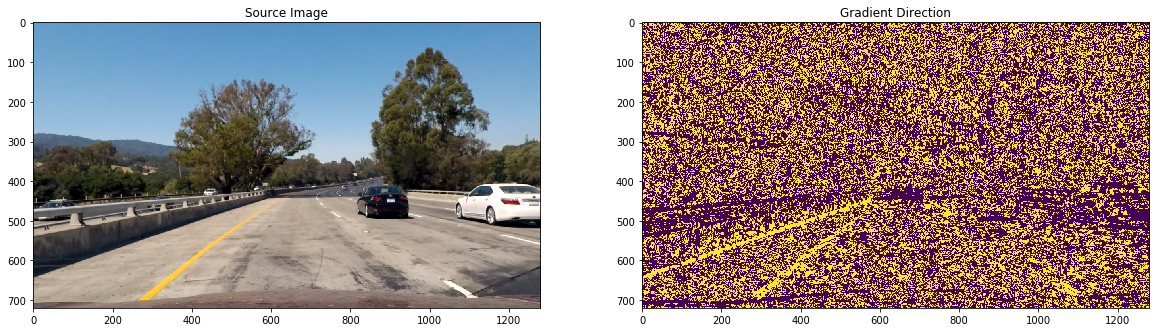

In [91]:
def dir_thresh(img, sobel_kernel = 9, thresh = (0, np.pi/2)):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    # Take the gradient in x and y
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize = sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize = sobel_kernel)

    # Take the absolute value of the x and y gradients, 
    abs_sobelx = np.absolute(sobelx)
    abs_sobely = np.absolute(sobely)
    
    # Calculate the direction of the gradient by using np.arctan2()
    gradient_direction = np.arctan2(abs_sobely, abs_sobelx)
    
    # Apply a threshold
    binary_output =  np.zeros_like(gradient_direction)
    binary_output[(gradient_direction > thresh[0]) & (gradient_direction < thresh[1])] = 1

    # Return the binary image
    return binary_output

# compute gradient direction
directional_gradient_binary = dir_thresh(RGB_undistorderd_img, sobel_kernel = 15, thresh=(0.7, 1.3))

# plot
f, axarr = plt.subplots(1, 2, figsize=(20, 20))
axarr[0].imshow(RGB_undistorderd_img)
axarr[0].set_title('Source Image')
axarr[1].imshow(directional_gradient_binary)
axarr[1].set_title('Gradient Direction')

### 3-4: Color threshold

Text(0.5,1,'Color Threshold')

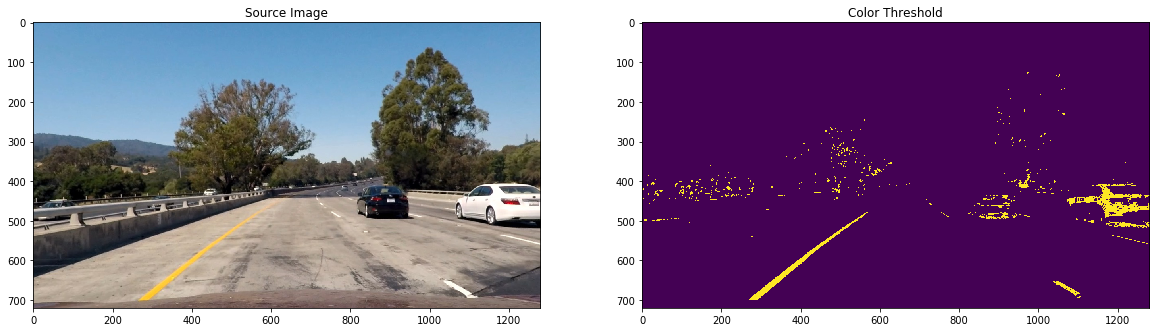

In [92]:
def color_thresh(img, thresh = (170, 255)):
    # Convert to HLS space
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    
    # Selecting the S Channel as it has the best performance for this specific task
    hls_s_channel = hls[:, :, 2] 
    
    binary_output = np.zeros_like(hls_s_channel)
    binary_output[(hls_s_channel >= thresh[0]) & (hls_s_channel <= thresh[1])] = 1

    # Return the binary image
    return binary_output

# compute color threshold
color_threshold_binary = color_thresh(RGB_undistorderd_img, thresh = (180, 255))

# plot
f, axarr = plt.subplots(1, 2, figsize=(20, 20))
axarr[0].imshow(RGB_undistorderd_img)
axarr[0].set_title('Source Image')
axarr[1].imshow(color_threshold_binary)
axarr[1].set_title('Color Threshold')

### 3-5: Combining all different thresholds

Text(0.5,1,'Combined Threshod')

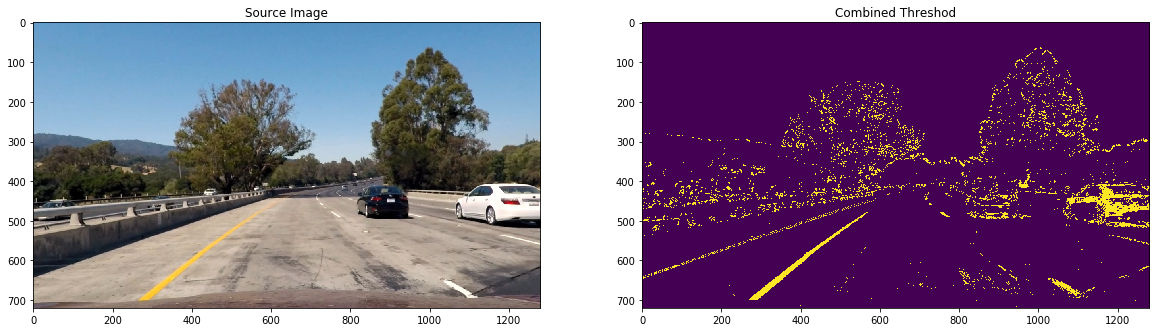

In [93]:
def combined_threshs(gradient_x_binary, gradient_y_binary, magnitude_gradient_binary, directional_gradient_binary, color_threshold_binary, ksize = 15):
    
    # Combining all different thresholds
    combined_threshod_binary = np.zeros_like(color_threshold_binary)
    combined_threshod_binary[((gradient_x_binary == 1) & (gradient_y_binary == 1)) | ((magnitude_gradient_binary == 1) & (directional_gradient_binary == 1)) | (color_threshold_binary == 1)] = 1

    return combined_threshod_binary



# Run the function
combined_threshod_binary = combined_threshs(gradient_x_binary, gradient_y_binary, magnitude_gradient_binary, directional_gradient_binary, color_threshold_binary, ksize = 15)

# plot
f, axarr = plt.subplots(1, 2, figsize=(20, 20))
axarr[0].imshow(RGB_undistorderd_img)
axarr[0].set_title('Source Image')
axarr[1].imshow(combined_threshod_binary)
axarr[1].set_title('Combined Threshod')

# 4- Apply a perspective transform to rectify binary image ("birds-eye view").

Text(0.5,1,'Wraped img')

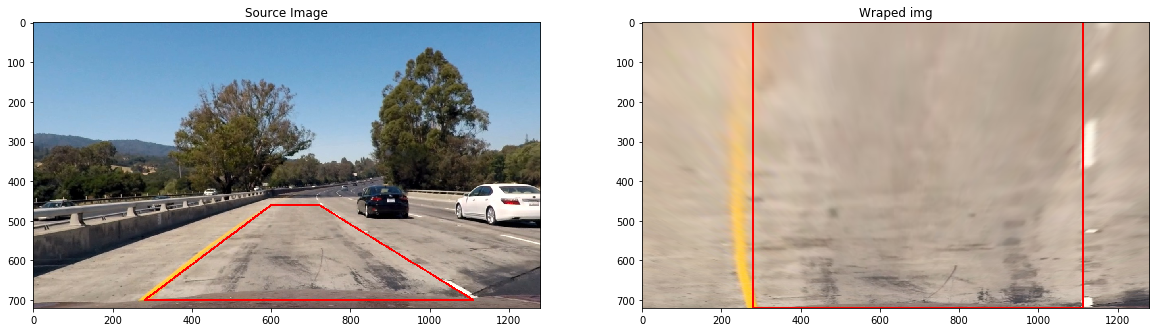

In [94]:
def warp(img):
    
    # Define calibration box in source (original) and destination (desired or warped) coordinates
    img_size = (img.shape[1], img.shape[0])
    
    # Source points
    src = np.float32(
        [[280,700],   # bottom-left
        [600,460],   # top-left
        [720,460],   # top-right
        [1110,700]]) # bottom-right

    # Destination points
    dst = np.float32(
        [[280,  img_size[1]],  # Bottom left
         [280,    0],  # Top left
         [1110,   0],  # Top right
         [1110, img_size[1]]]) # Bottom right   
    
    # Compute the perspective transfor, M
    M = cv2.getPerspectiveTransform(src, dst)
    
    # Compute the inverse perspective transfor, M_inv
    M_inv = cv2.getPerspectiveTransform(dst, src)
    
    # Create warped image - uses linear interpolation
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)

    return warped, M, M_inv, src, dst

warped_img, M, M_inv, src, dst = warp(RGB_undistorderd_img)

# plot
f, axarr = plt.subplots(1, 2, figsize = (20, 20))
RGB_undistorderd_img = cv2.polylines(RGB_undistorderd_img, np.int32([src]), True, (255, 0, 0), 3) 
axarr[0].imshow(RGB_undistorderd_img)
axarr[0].set_title('Source Image')
warped_img = cv2.polylines(warped_img, np.int32([dst]), True, (255, 0, 0), 3)
axarr[1].imshow(warped_img)
axarr[1].set_title('Wraped img')

# 5: Detect lane pixels and fit to find the lane boundary.

### 5-1: Applying the perspective transform to the combined thresholded image

Text(0.5,1,'Wraped thresholded img')

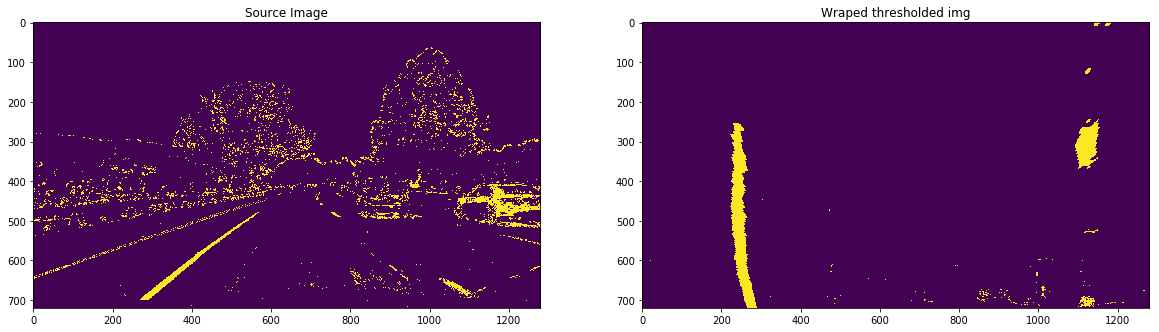

In [96]:
warped_thresholded_img, M, M_inv, src, dst = warp(combined_threshod_binary)

# plot
f, axarr = plt.subplots(1, 2, figsize = (20, 20))
axarr[0].imshow(combined_threshod_binary)
axarr[0].set_title('Source Image')
axarr[1].imshow(warped_thresholded_img)
axarr[1].set_title('Wraped thresholded img')

### 5-2: Computing the histogram of the thresholded wraped image

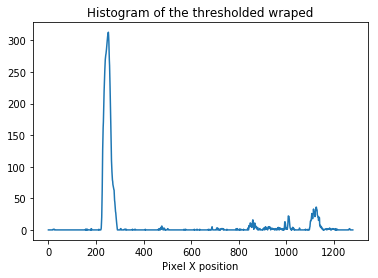

In [97]:
def hist(img):
    histogram = np.sum(img[img.shape[0]//2:, :], axis = 0)
    return histogram

histogram = hist(warped_thresholded_img)

# Plot the results
plt.title('Histogram of the thresholded wraped')
plt.xlabel('Pixel X position')
plt.plot(histogram)

### 5-3: Sliding Windows and Fit a Polynomial

In [98]:
def find_lane_pixels(img):
    
    # Take a histogram of the bottom half of the image
    histogram = hist(img)

    # create an output image to draw on and visualize the result 
    out_img = np.dstack((img, img, img))
    
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    
    # Choose the number of sliding windows
    nwindows = 9
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    
    # Set height of windows
    window_height = np.int(img.shape[0]//nwindows)
        
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = img.nonzero()
    nonzerox = np.array(nonzero[1])   
    nonzeroy = np.array(nonzero[0])
   
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = img.shape[0] - (window + 1)*window_height
        win_y_high = img.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin

        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),
                      (win_xleft_high,win_y_high), (0,255,0), 4) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),
                      (win_xright_high,win_y_high), (0,255,0), 4) 

        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
                          (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
                           (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        pass
    
    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    return leftx, lefty, rightx, righty, out_img 

Text(0.5,1,'Detected lane lines')

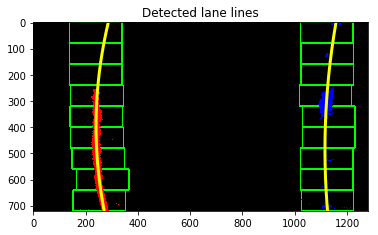

In [99]:
def fit_polynomial(img):
    #Find our lane pixels first
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(img)
    
    #Fit a second order polynomial
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, img.shape[0] - 1, img.shape[0])
    
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
            print('The function failed to fit a line!')
            left_fitx = 1*ploty**2 + 1*ploty
            right_fitx = 1*ploty**2 + 1*ploty
            
    #Visualizatio
    # colors in the left and right lane regions
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]
    
    # Plots the left and right polynomials on the lane lines
    plt.plot(left_fitx, ploty, color = 'yellow', linewidth = 3)
    plt.plot(right_fitx, ploty, color = "yellow", linewidth = 3)
    
    return out_img, left_fit, right_fit, leftx, lefty, rightx, righty


out_img, left_fit, right_fit, leftx, lefty, rightx, righty = fit_polynomial(warped_thresholded_img)

# plot
plt.imshow(out_img)
plt.title('Detected lane lines')

### 5-4: Skip the sliding windows step once lane lines are detected

In [100]:
def fit_poly (img_shape, leftx, lefty, rightx, righty):
    # Fitting a second order polynomial to each lane line
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, img_shape[0]-1, img_shape[0])
    
    # Calculatue both polynomials
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    return left_fitx, right_fitx, ploty

Text(0.5,1,'Lane Line Detected')

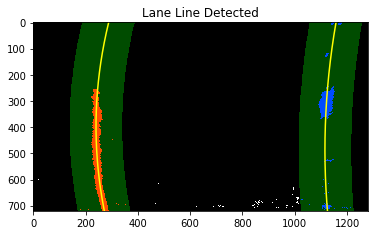

In [101]:
def search_around_poly(binary_warped):
    
    margin = 100
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
                    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
                    left_fit[1]*nonzeroy + left_fit[2] + margin))) 

    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
                    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
                    right_fit[1]*nonzeroy + right_fit[2] + margin))) 
    
    
    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    # If any of the lines could not be found, 
    if (leftx.size == 0 or rightx.size == 0):
        return find_lane_pixels(binary_warped)
    
    left_fitx, right_fitx, ploty = fit_poly(binary_warped.shape, leftx, lefty, rightx, righty)
        
    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(out_img)
    
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    
    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx - margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx + margin, ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx - margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx + margin, ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))
    
    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    
    #plot the polynomial lines onto the image
    plt.plot(left_fitx, ploty, color = 'yellow')
    plt.plot(right_fitx, ploty, color = 'yellow')
    
    return result, left_fitx, right_fitx, ploty


result, left_fitx, right_fitx, ploty = search_around_poly(warped_thresholded_img)

# plot
plt.imshow(result)
plt.title('Lane Line Detected')

# 6: Determine the curvature of the lane and vehicle position with respect to center.

### 6-1: Determining the Curvature of the lane line

In [102]:
def measure_curvature(left_fitx, right_fitx):
    
    left_fitx_rev = left_fitx[::-1]  # Reverse to match top-to-bottom in y
    right_fitx_rev = right_fitx[::-1]  # Reverse to match top-to-bottom in y
    
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    
    # Fit a second order polynomial to pixel positions
    left_fit_cr = np.polyfit(ploty*ym_per_pix, left_fitx_rev*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, right_fitx_rev*xm_per_pix, 2)                                                          

    # Fit new polynomials to x,y in world space
    y_eval = np.max(ploty)

    # Calculate the radius of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    
    # Now our radius of curvature is in meters
    return left_curverad, right_curverad


left_curverad, right_curverad = measure_curvature(left_fitx, right_fitx)

# Print the results
print('Left line curvature:', left_curverad, 'm')
print('Right line curvature:', right_curverad, 'm')

Left line curvature: 537.756833883 m
Right line curvature: 923.013507081 m


### 6-2: Compute the car offset

In [103]:
# You can assume the camera is mounted at the center of the car, 
#such that the lane center is the midpoint at the bottom of the 
#image between the two lines you've detected. 
#The offset of the lane center from the center of the image 
#(converted from pixels to meters) is your distance from the center 
# of the lane.

def car_offset(binary_warped, left_fit, right_fit):
    
    # Define conversion in x from pixels space to meters
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    
    # The y value of the bottom of the image 
    y_max = binary_warped.shape[0]
    
    # Left line position at the bottom of the image
    left_fit_pos = left_fit[0]*y_max**2 + left_fit[1]*y_max + left_fit[2]
    # Right line position at the bottom of the image
    right_fit_pos = right_fit[0]*y_max**2 + right_fit[1]*y_max + right_fit[2] 
    
    # Center of the lane line (in x) 
    center_lanes_x_pos = (left_fit_pos + right_fit_pos)//2
    
    # Car position WRT the lane line center
    # (the negative value means that the car is on the felt hand side of the center of the lane and vice versa)
    car_pos = ((binary_warped.shape[1]//2) - center_lanes_x_pos) * xm_per_pix 
    return car_pos

car_pos = car_offset(warped_thresholded_img, left_fit, right_fit)
print('Car position WRT the Lane Line center  = ', car_pos, 'm.')

Car position WRT the Lane Line center  =  -0.306571428571 m.


# 7: Warp the detected lane boundaries back onto the original image

Text(0.5,1,'Detected Lane')

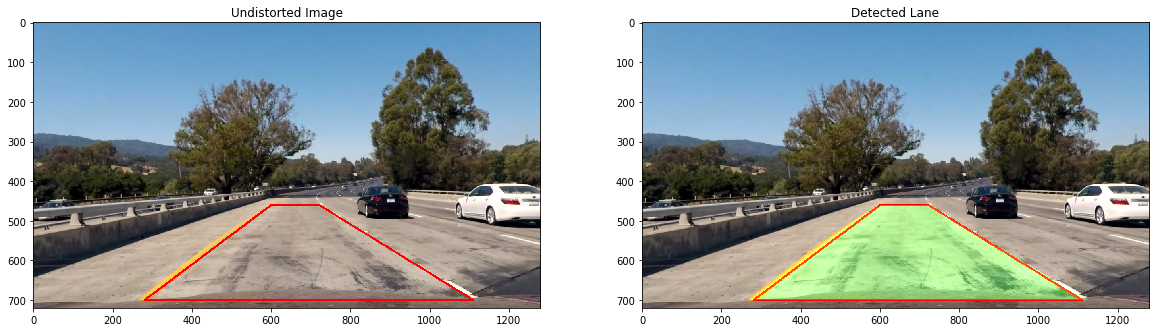

In [104]:
def print_lane(undistorted_img, warped_thresholded_img, left_fitx, right_fitx, ploty, M_inv):
    
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped_thresholded_img).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, M_inv, (undistorted_img.shape[1], undistorted_img.shape[0])) 

    # Combine the result with the original image
    lane = cv2.addWeighted(undistorted_img, 1, newwarp, 0.3, 0)
    return lane


# Run the function
lane = print_lane(RGB_undistorderd_img, warped_thresholded_img, left_fitx, right_fitx, ploty, M_inv)

# plot
f, axarr = plt.subplots(1, 2, figsize = (20, 20))
axarr[0].imshow(RGB_undistorderd_img)
axarr[0].set_title('Undistorted Image')
axarr[1].imshow(lane)
axarr[1].set_title('Detected Lane')

# 8: Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.


Text(0.5,1,'Detected Lane')

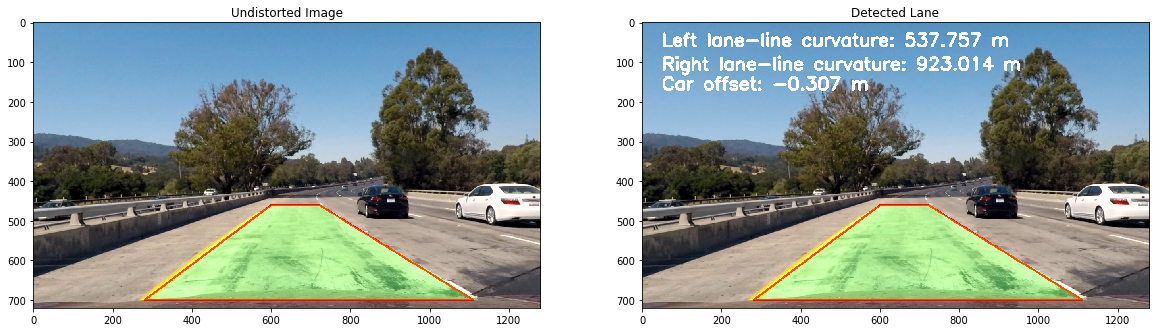

In [105]:
def print_inf(img, binary_warped, leftx, rightx):
    
    # Curvature
    left_curverad, right_curverad = measure_curvature(left_fitx, right_fitx)
    
    # Car offset
    car_pos = car_offset(binary_warped, left_fit, right_fit)
    
    # Copy the original image to wrtite on it
    out_img = img.copy()
    
    # Display Curvature information
    cv2.putText(out_img, 'Left lane-line curvature: {:.3f} m'.format(left_curverad), (50, 60), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (255,255,255), 5)
    cv2.putText(out_img, 'Right lane-line curvature: {:.3f} m'.format(right_curverad), (50, 120), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (255,255,255), 5)
    # Display Car offset information 
    cv2.putText(out_img, 'Car offset: {:.3f} m'.format(car_pos), (50, 170), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (255,255,255), 5)
    
    return out_img

# Run the function
out_img = print_inf(lane, warped_thresholded_img, leftx, rightx)

# plot
f, axarr = plt.subplots(1, 2, figsize = (20, 20))
axarr[0].imshow(lane)
axarr[0].set_title('Undistorted Image')
axarr[1].imshow(out_img)
axarr[1].set_title('Detected Lane')

# PipeLine

In [111]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

class PipeLine:
    def __init__(self, imgs):
        
        # Gathering all images for calibrating camera in a list
        calibrating_images = glob.glob(imgs)

        # Calibrating the camera
        self.ret, self.mtx, self.dist, self.rvecs, self.tvecs = calibrate_camera(calibrating_images)
        
    def __call__(self, img):
        
        # Undistord image
        RGB_undistorderd_img = cv2.undistort(img, mtx, dist, None, mtx)

        # Calculate directional gradient
        gradient_x_binary = abs_sobel_thresh(RGB_undistorderd_img, orient = 'x', sobel_kernel = 15, thresh = (20, 100))
        gradient_y_binary = abs_sobel_thresh(RGB_undistorderd_img, orient = 'y', sobel_kernel = 15, thresh = (20, 100))
        # Calculate gradient magnitude 
        magnitude_gradient_binary = mag_thres(RGB_undistorderd_img, sobel_kernel = 15, thresh= (60, 100))
        # Calculate gradient direction
        directional_gradient_binary = dir_thresh(RGB_undistorderd_img, sobel_kernel = 15, thresh=(0.7, 1.3))
        # Calculate color threshold
        color_threshold_binary = color_thresh(RGB_undistorderd_img, thresh = (180, 255))
        # Combine all the thresholds to identify the lane lines
        combined_threshod_binary = combined_threshs(gradient_x_binary, gradient_y_binary, magnitude_gradient_binary, directional_gradient_binary, color_threshold_binary, ksize = 15)
  
        # Apply a perspective transform to rectify binary image ("birds-eye view")
        warped_img, M, M_inv, src, dst = warp(RGB_undistorderd_img)
        
        # 
        warped_thresholded_img, M, M_inv, src, dst = warp(combined_threshod_binary)
        out_img, left_fit, right_fit, leftx, lefty, rightx, righty = fit_polynomial(warped_thresholded_img)
        result, left_fitx, right_fitx, ploty = search_around_poly(warped_thresholded_img)
        
        # inf
        left_curverad, right_curverad = measure_curvature(left_fitx, right_fitx)
        car_pos = car_offset(warped_thresholded_img, left_fit, right_fit)
        
        # lane
        lane = print_lane(RGB_undistorderd_img, warped_thresholded_img, left_fitx, right_fitx, ploty, M_inv)
        out_img_lane = print_inf(lane, warped_thresholded_img, leftx, rightx)
        
        return out_img_lane      
        
        

coucou
[MoviePy] >>>> Building video ./project_video_solution.mp4
[MoviePy] Writing video ./project_video_solution.mp4


  0%|          | 0/1261 [00:00<?, ?it/s]

coucou


  0%|          | 1/1261 [00:00<07:32,  2.78it/s]

coucou


  0%|          | 2/1261 [00:00<07:49,  2.68it/s]

coucou


  0%|          | 3/1261 [00:01<07:47,  2.69it/s]

coucou


  0%|          | 4/1261 [00:01<07:45,  2.70it/s]

coucou


  0%|          | 5/1261 [00:01<07:39,  2.73it/s]

coucou


  0%|          | 6/1261 [00:02<07:34,  2.76it/s]

coucou


  1%|          | 7/1261 [00:02<07:33,  2.77it/s]

coucou


  1%|          | 8/1261 [00:02<07:27,  2.80it/s]

coucou


  1%|          | 9/1261 [00:03<07:23,  2.82it/s]

coucou


  1%|          | 10/1261 [00:03<07:21,  2.84it/s]

coucou


  1%|          | 11/1261 [00:03<07:23,  2.82it/s]

coucou


  1%|          | 12/1261 [00:04<07:23,  2.82it/s]

coucou


  1%|          | 13/1261 [00:04<07:24,  2.81it/s]

coucou


  1%|          | 14/1261 [00:05<07:24,  2.80it/s]

coucou


  1%|          | 15/1261 [00:05<07:28,  2.78it/s]

coucou


  1%|▏         | 16/1261 [00:05<07:25,  2.80it/s]

coucou


  1%|▏         | 17/1261 [00:06<07:27,  2.78it/s]

coucou


  1%|▏         | 18/1261 [00:06<07:25,  2.79it/s]

coucou


  2%|▏         | 19/1261 [00:06<07:27,  2.78it/s]

coucou


  2%|▏         | 20/1261 [00:07<07:25,  2.79it/s]

coucou


  2%|▏         | 21/1261 [00:07<07:26,  2.78it/s]

coucou


  2%|▏         | 22/1261 [00:07<07:24,  2.78it/s]

coucou


  2%|▏         | 23/1261 [00:08<07:26,  2.77it/s]

coucou


  2%|▏         | 24/1261 [00:08<07:30,  2.75it/s]

coucou


  2%|▏         | 25/1261 [00:09<07:29,  2.75it/s]

coucou


  2%|▏         | 26/1261 [00:09<07:26,  2.77it/s]

coucou


  2%|▏         | 27/1261 [00:09<07:24,  2.78it/s]

coucou


  2%|▏         | 28/1261 [00:10<07:25,  2.77it/s]

coucou


  2%|▏         | 29/1261 [00:10<07:24,  2.77it/s]

coucou


  2%|▏         | 30/1261 [00:10<07:25,  2.76it/s]

coucou


  2%|▏         | 31/1261 [00:11<07:22,  2.78it/s]

coucou


  3%|▎         | 32/1261 [00:11<07:23,  2.77it/s]

coucou


  3%|▎         | 33/1261 [00:11<07:24,  2.76it/s]

coucou


  3%|▎         | 34/1261 [00:12<07:23,  2.77it/s]

coucou


  3%|▎         | 35/1261 [00:12<07:21,  2.78it/s]

coucou


  3%|▎         | 36/1261 [00:12<07:23,  2.76it/s]

coucou


  3%|▎         | 37/1261 [00:13<07:22,  2.77it/s]

coucou


  3%|▎         | 38/1261 [00:13<07:24,  2.75it/s]

coucou


  3%|▎         | 39/1261 [00:14<07:24,  2.75it/s]

coucou


  3%|▎         | 40/1261 [00:14<07:28,  2.72it/s]

coucou


  3%|▎         | 41/1261 [00:14<07:25,  2.74it/s]

coucou


  3%|▎         | 42/1261 [00:15<07:24,  2.74it/s]

coucou


  3%|▎         | 43/1261 [00:15<09:07,  2.22it/s]

coucou


  3%|▎         | 44/1261 [00:16<09:03,  2.24it/s]

coucou


  4%|▎         | 45/1261 [00:16<09:16,  2.18it/s]

coucou


  4%|▎         | 46/1261 [00:17<09:23,  2.16it/s]

coucou


  4%|▎         | 47/1261 [00:17<09:06,  2.22it/s]

coucou


  4%|▍         | 48/1261 [00:18<09:14,  2.19it/s]

coucou


  4%|▍         | 49/1261 [00:18<08:57,  2.26it/s]

coucou


  4%|▍         | 50/1261 [00:18<09:01,  2.24it/s]

coucou


  4%|▍         | 51/1261 [00:19<08:51,  2.28it/s]

coucou


  4%|▍         | 52/1261 [00:19<09:04,  2.22it/s]

coucou


  4%|▍         | 53/1261 [00:20<08:55,  2.25it/s]

coucou


  4%|▍         | 54/1261 [00:20<09:02,  2.22it/s]

coucou


  4%|▍         | 55/1261 [00:21<08:51,  2.27it/s]

coucou


  4%|▍         | 56/1261 [00:21<08:56,  2.25it/s]

coucou


  5%|▍         | 57/1261 [00:22<09:05,  2.21it/s]

coucou


  5%|▍         | 58/1261 [00:22<08:57,  2.24it/s]

coucou


  5%|▍         | 59/1261 [00:23<09:04,  2.21it/s]

coucou


  5%|▍         | 60/1261 [00:23<08:52,  2.26it/s]

coucou


  5%|▍         | 61/1261 [00:23<09:03,  2.21it/s]

coucou


  5%|▍         | 62/1261 [00:24<08:54,  2.24it/s]

coucou


  5%|▍         | 63/1261 [00:24<09:01,  2.21it/s]

coucou


  5%|▌         | 64/1261 [00:25<08:51,  2.25it/s]

coucou


  5%|▌         | 65/1261 [00:25<08:56,  2.23it/s]

coucou


  5%|▌         | 66/1261 [00:26<08:45,  2.27it/s]

coucou


  5%|▌         | 67/1261 [00:26<08:56,  2.22it/s]

coucou


  5%|▌         | 68/1261 [00:27<09:08,  2.17it/s]

coucou


  5%|▌         | 69/1261 [00:27<08:55,  2.23it/s]

coucou


  6%|▌         | 70/1261 [00:27<09:00,  2.20it/s]

coucou


  6%|▌         | 71/1261 [00:28<08:47,  2.25it/s]

coucou


  6%|▌         | 72/1261 [00:28<08:50,  2.24it/s]

coucou


  6%|▌         | 73/1261 [00:29<08:57,  2.21it/s]

coucou


  6%|▌         | 74/1261 [00:29<09:12,  2.15it/s]

coucou


  6%|▌         | 75/1261 [00:30<08:58,  2.20it/s]

coucou


  6%|▌         | 76/1261 [00:30<09:01,  2.19it/s]

coucou


  6%|▌         | 77/1261 [00:31<08:48,  2.24it/s]

coucou


  6%|▌         | 78/1261 [00:31<08:52,  2.22it/s]

coucou


  6%|▋         | 79/1261 [00:32<08:59,  2.19it/s]

coucou


  6%|▋         | 80/1261 [00:32<08:49,  2.23it/s]

coucou


  6%|▋         | 81/1261 [00:32<08:57,  2.20it/s]

coucou


  7%|▋         | 82/1261 [00:33<08:45,  2.24it/s]

coucou


  7%|▋         | 83/1261 [00:33<08:53,  2.21it/s]

coucou


  7%|▋         | 84/1261 [00:34<08:42,  2.25it/s]

coucou


  7%|▋         | 85/1261 [00:34<08:57,  2.19it/s]

coucou


  7%|▋         | 86/1261 [00:35<08:52,  2.21it/s]

coucou


  7%|▋         | 87/1261 [00:35<09:08,  2.14it/s]

coucou


  7%|▋         | 88/1261 [00:36<08:55,  2.19it/s]

coucou


  7%|▋         | 89/1261 [00:36<09:02,  2.16it/s]

coucou


  7%|▋         | 90/1261 [00:37<09:02,  2.16it/s]

coucou


  7%|▋         | 91/1261 [00:37<09:10,  2.13it/s]

coucou


  7%|▋         | 92/1261 [00:38<09:02,  2.16it/s]

coucou


  7%|▋         | 93/1261 [00:38<09:07,  2.13it/s]

coucou


  7%|▋         | 94/1261 [00:38<08:59,  2.16it/s]

coucou


  8%|▊         | 95/1261 [00:39<08:56,  2.17it/s]

coucou


  8%|▊         | 96/1261 [00:39<09:00,  2.16it/s]

coucou


  8%|▊         | 97/1261 [00:40<08:50,  2.20it/s]

coucou


  8%|▊         | 98/1261 [00:40<08:54,  2.18it/s]

coucou


  8%|▊         | 99/1261 [00:41<08:41,  2.23it/s]

coucou


  8%|▊         | 100/1261 [00:41<08:44,  2.21it/s]

coucou


  8%|▊         | 101/1261 [00:42<08:37,  2.24it/s]

coucou


  8%|▊         | 102/1261 [00:42<08:40,  2.23it/s]

coucou


  8%|▊         | 103/1261 [00:43<08:47,  2.19it/s]

coucou


  8%|▊         | 104/1261 [00:43<09:22,  2.06it/s]

coucou


  8%|▊         | 105/1261 [00:44<09:14,  2.09it/s]

coucou


  8%|▊         | 106/1261 [00:44<08:57,  2.15it/s]

coucou


  8%|▊         | 107/1261 [00:44<09:00,  2.13it/s]

coucou


  9%|▊         | 108/1261 [00:45<08:47,  2.19it/s]

coucou


  9%|▊         | 109/1261 [00:45<08:50,  2.17it/s]

coucou


  9%|▊         | 110/1261 [00:46<08:40,  2.21it/s]

coucou


  9%|▉         | 111/1261 [00:46<08:45,  2.19it/s]

coucou


  9%|▉         | 112/1261 [00:47<08:33,  2.24it/s]

coucou


  9%|▉         | 113/1261 [00:47<08:41,  2.20it/s]

coucou


  9%|▉         | 114/1261 [00:48<08:33,  2.23it/s]

coucou


  9%|▉         | 115/1261 [00:48<08:38,  2.21it/s]

coucou


  9%|▉         | 116/1261 [00:48<08:22,  2.28it/s]

coucou


  9%|▉         | 117/1261 [00:49<08:32,  2.23it/s]

coucou


  9%|▉         | 118/1261 [00:49<08:20,  2.28it/s]

coucou


  9%|▉         | 119/1261 [00:50<08:30,  2.24it/s]

coucou


 10%|▉         | 120/1261 [00:50<08:20,  2.28it/s]

coucou


 10%|▉         | 121/1261 [00:51<08:30,  2.23it/s]

coucou


 10%|▉         | 122/1261 [00:51<09:17,  2.04it/s]

coucou


 10%|▉         | 123/1261 [00:52<08:57,  2.12it/s]

coucou


 10%|▉         | 124/1261 [00:52<08:28,  2.24it/s]

coucou


 10%|▉         | 125/1261 [00:53<08:21,  2.27it/s]

coucou


 10%|▉         | 126/1261 [00:53<08:04,  2.34it/s]

coucou


 10%|█         | 127/1261 [00:53<08:05,  2.34it/s]

coucou


 10%|█         | 128/1261 [00:54<07:52,  2.40it/s]

coucou


 10%|█         | 129/1261 [00:54<07:53,  2.39it/s]

coucou


 10%|█         | 130/1261 [00:55<08:20,  2.26it/s]

coucou


 10%|█         | 131/1261 [00:55<08:00,  2.35it/s]

coucou


 10%|█         | 132/1261 [00:55<08:03,  2.33it/s]

coucou


 11%|█         | 133/1261 [00:56<07:50,  2.40it/s]

coucou


 11%|█         | 134/1261 [00:56<07:48,  2.40it/s]

coucou


 11%|█         | 135/1261 [00:57<07:55,  2.37it/s]

coucou


 11%|█         | 136/1261 [00:57<07:41,  2.44it/s]

coucou


 11%|█         | 137/1261 [00:58<07:47,  2.41it/s]

coucou


 11%|█         | 138/1261 [00:58<07:36,  2.46it/s]

coucou


 11%|█         | 139/1261 [00:58<07:43,  2.42it/s]

coucou


 11%|█         | 140/1261 [00:59<07:33,  2.47it/s]

coucou


 11%|█         | 141/1261 [00:59<07:43,  2.42it/s]

coucou


 11%|█▏        | 142/1261 [01:00<07:35,  2.46it/s]

coucou


 11%|█▏        | 143/1261 [01:00<07:42,  2.42it/s]

coucou


 11%|█▏        | 144/1261 [01:00<07:30,  2.48it/s]

coucou


 11%|█▏        | 145/1261 [01:01<07:39,  2.43it/s]

coucou


 12%|█▏        | 146/1261 [01:01<07:32,  2.46it/s]

coucou


 12%|█▏        | 147/1261 [01:02<07:42,  2.41it/s]

coucou


 12%|█▏        | 148/1261 [01:02<07:34,  2.45it/s]

coucou


 12%|█▏        | 149/1261 [01:02<07:41,  2.41it/s]

coucou


 12%|█▏        | 150/1261 [01:03<07:34,  2.44it/s]

coucou


 12%|█▏        | 151/1261 [01:03<07:42,  2.40it/s]

coucou


 12%|█▏        | 152/1261 [01:04<07:29,  2.47it/s]

coucou


 12%|█▏        | 153/1261 [01:04<07:39,  2.41it/s]

coucou


 12%|█▏        | 154/1261 [01:04<07:28,  2.47it/s]

coucou


 12%|█▏        | 155/1261 [01:05<07:35,  2.43it/s]

coucou


 12%|█▏        | 156/1261 [01:05<07:28,  2.46it/s]

coucou


 12%|█▏        | 157/1261 [01:06<07:38,  2.41it/s]

coucou


 13%|█▎        | 158/1261 [01:06<07:28,  2.46it/s]

coucou


 13%|█▎        | 159/1261 [01:07<07:35,  2.42it/s]

coucou


 13%|█▎        | 160/1261 [01:07<07:24,  2.48it/s]

coucou


 13%|█▎        | 161/1261 [01:07<07:30,  2.44it/s]

coucou


 13%|█▎        | 162/1261 [01:08<07:20,  2.50it/s]

coucou


 13%|█▎        | 163/1261 [01:08<07:30,  2.44it/s]

coucou


 13%|█▎        | 164/1261 [01:09<07:39,  2.39it/s]

coucou


 13%|█▎        | 165/1261 [01:09<07:39,  2.38it/s]

coucou


 13%|█▎        | 166/1261 [01:09<07:26,  2.45it/s]

coucou


 13%|█▎        | 167/1261 [01:10<07:32,  2.42it/s]

coucou


 13%|█▎        | 168/1261 [01:10<07:21,  2.48it/s]

coucou


 13%|█▎        | 169/1261 [01:11<07:24,  2.46it/s]

coucou


 13%|█▎        | 170/1261 [01:11<07:15,  2.51it/s]

coucou


 14%|█▎        | 171/1261 [01:11<07:24,  2.45it/s]

coucou


 14%|█▎        | 172/1261 [01:12<07:13,  2.51it/s]

coucou


 14%|█▎        | 173/1261 [01:12<07:20,  2.47it/s]

coucou


 14%|█▍        | 174/1261 [01:13<07:11,  2.52it/s]

coucou


 14%|█▍        | 175/1261 [01:13<07:18,  2.47it/s]

coucou


 14%|█▍        | 176/1261 [01:13<07:10,  2.52it/s]

coucou


 14%|█▍        | 177/1261 [01:14<07:24,  2.44it/s]

coucou


 14%|█▍        | 178/1261 [01:14<07:15,  2.49it/s]

coucou


 14%|█▍        | 179/1261 [01:15<07:26,  2.43it/s]

coucou


 14%|█▍        | 180/1261 [01:15<07:20,  2.45it/s]

coucou


 14%|█▍        | 181/1261 [01:15<07:29,  2.40it/s]

coucou


 14%|█▍        | 182/1261 [01:16<07:19,  2.45it/s]

coucou


 15%|█▍        | 183/1261 [01:16<07:28,  2.40it/s]

coucou


 15%|█▍        | 184/1261 [01:17<07:17,  2.46it/s]

coucou


 15%|█▍        | 185/1261 [01:17<07:24,  2.42it/s]

coucou


 15%|█▍        | 186/1261 [01:18<07:14,  2.47it/s]

coucou


 15%|█▍        | 187/1261 [01:18<07:21,  2.43it/s]

coucou


 15%|█▍        | 188/1261 [01:18<07:10,  2.50it/s]

coucou


 15%|█▍        | 189/1261 [01:19<07:17,  2.45it/s]

coucou


 15%|█▌        | 190/1261 [01:19<07:12,  2.47it/s]

coucou


 15%|█▌        | 191/1261 [01:20<07:21,  2.42it/s]

coucou


 15%|█▌        | 192/1261 [01:20<07:13,  2.47it/s]

coucou


 15%|█▌        | 193/1261 [01:20<07:20,  2.43it/s]

coucou


 15%|█▌        | 194/1261 [01:21<08:04,  2.20it/s]

coucou


 15%|█▌        | 195/1261 [01:21<08:03,  2.21it/s]

coucou


 16%|█▌        | 196/1261 [01:22<07:50,  2.26it/s]

coucou


 16%|█▌        | 197/1261 [01:22<08:01,  2.21it/s]

coucou


 16%|█▌        | 198/1261 [01:23<07:50,  2.26it/s]

coucou


 16%|█▌        | 199/1261 [01:23<07:55,  2.23it/s]

coucou


 16%|█▌        | 200/1261 [01:24<07:46,  2.28it/s]

coucou


 16%|█▌        | 201/1261 [01:24<07:53,  2.24it/s]

coucou


 16%|█▌        | 202/1261 [01:24<07:40,  2.30it/s]

coucou


 16%|█▌        | 203/1261 [01:25<07:48,  2.26it/s]

coucou


 16%|█▌        | 204/1261 [01:25<07:38,  2.31it/s]

coucou


 16%|█▋        | 205/1261 [01:26<07:47,  2.26it/s]

coucou


 16%|█▋        | 206/1261 [01:26<07:40,  2.29it/s]

coucou


 16%|█▋        | 207/1261 [01:27<07:49,  2.25it/s]

coucou


 16%|█▋        | 208/1261 [01:27<07:39,  2.29it/s]

coucou


 17%|█▋        | 209/1261 [01:28<07:46,  2.26it/s]

coucou


 17%|█▋        | 210/1261 [01:28<07:38,  2.29it/s]

coucou


 17%|█▋        | 211/1261 [01:28<07:46,  2.25it/s]

coucou


 17%|█▋        | 212/1261 [01:29<07:36,  2.30it/s]

coucou


 17%|█▋        | 213/1261 [01:29<07:43,  2.26it/s]

coucou


 17%|█▋        | 214/1261 [01:30<07:32,  2.31it/s]

coucou


 17%|█▋        | 215/1261 [01:30<07:39,  2.28it/s]

coucou


 17%|█▋        | 216/1261 [01:31<07:31,  2.31it/s]

coucou


 17%|█▋        | 217/1261 [01:31<07:46,  2.24it/s]

coucou


 17%|█▋        | 218/1261 [01:31<07:36,  2.29it/s]

coucou


 17%|█▋        | 219/1261 [01:32<07:46,  2.23it/s]

coucou


 17%|█▋        | 220/1261 [01:32<07:39,  2.26it/s]

coucou


 18%|█▊        | 221/1261 [01:33<07:48,  2.22it/s]

coucou


 18%|█▊        | 222/1261 [01:33<07:38,  2.26it/s]

coucou


 18%|█▊        | 223/1261 [01:34<07:47,  2.22it/s]

coucou


 18%|█▊        | 224/1261 [01:34<07:35,  2.28it/s]

coucou


 18%|█▊        | 225/1261 [01:35<07:42,  2.24it/s]

coucou


 18%|█▊        | 226/1261 [01:35<07:35,  2.27it/s]

coucou


 18%|█▊        | 227/1261 [01:36<07:42,  2.24it/s]

coucou


 18%|█▊        | 228/1261 [01:36<07:30,  2.29it/s]

coucou


 18%|█▊        | 229/1261 [01:36<07:41,  2.24it/s]

coucou


 18%|█▊        | 230/1261 [01:37<07:35,  2.27it/s]

coucou


 18%|█▊        | 231/1261 [01:37<07:42,  2.23it/s]

coucou


 18%|█▊        | 232/1261 [01:38<07:33,  2.27it/s]

coucou


 18%|█▊        | 233/1261 [01:38<07:42,  2.22it/s]

coucou


 19%|█▊        | 234/1261 [01:39<07:31,  2.27it/s]

coucou


 19%|█▊        | 235/1261 [01:39<07:40,  2.23it/s]

coucou


 19%|█▊        | 236/1261 [01:39<07:31,  2.27it/s]

coucou


 19%|█▉        | 237/1261 [01:40<07:42,  2.22it/s]

coucou


 19%|█▉        | 238/1261 [01:40<07:30,  2.27it/s]

coucou


 19%|█▉        | 239/1261 [01:41<07:38,  2.23it/s]

coucou


 19%|█▉        | 240/1261 [01:41<07:31,  2.26it/s]

coucou


 19%|█▉        | 241/1261 [01:42<07:41,  2.21it/s]

coucou


 19%|█▉        | 242/1261 [01:42<07:37,  2.23it/s]

coucou


 19%|█▉        | 243/1261 [01:43<07:50,  2.17it/s]

coucou


 19%|█▉        | 244/1261 [01:43<07:36,  2.23it/s]

coucou


 19%|█▉        | 245/1261 [01:44<07:43,  2.19it/s]

coucou


 20%|█▉        | 246/1261 [01:44<07:34,  2.23it/s]

coucou


 20%|█▉        | 247/1261 [01:44<07:42,  2.19it/s]

coucou


 20%|█▉        | 248/1261 [01:45<07:31,  2.25it/s]

coucou


 20%|█▉        | 249/1261 [01:45<07:37,  2.21it/s]

coucou


 20%|█▉        | 250/1261 [01:46<07:27,  2.26it/s]

coucou


 20%|█▉        | 251/1261 [01:46<07:33,  2.23it/s]

coucou


 20%|█▉        | 252/1261 [01:47<07:22,  2.28it/s]

coucou


 20%|██        | 253/1261 [01:47<07:33,  2.22it/s]

coucou


 20%|██        | 254/1261 [01:48<07:25,  2.26it/s]

coucou


 20%|██        | 255/1261 [01:48<07:30,  2.23it/s]

coucou


 20%|██        | 256/1261 [01:48<07:21,  2.28it/s]

coucou


 20%|██        | 257/1261 [01:49<07:28,  2.24it/s]

coucou


 20%|██        | 258/1261 [01:49<07:18,  2.29it/s]

coucou


 21%|██        | 259/1261 [01:50<07:26,  2.24it/s]

coucou


 21%|██        | 260/1261 [01:50<07:19,  2.28it/s]

coucou


 21%|██        | 261/1261 [01:51<07:30,  2.22it/s]

coucou


 21%|██        | 262/1261 [01:51<07:25,  2.24it/s]

coucou


 21%|██        | 263/1261 [01:52<07:34,  2.20it/s]

coucou


 21%|██        | 264/1261 [01:52<07:26,  2.23it/s]

coucou


 21%|██        | 265/1261 [01:53<07:34,  2.19it/s]

coucou


 21%|██        | 266/1261 [01:53<07:24,  2.24it/s]

coucou


 21%|██        | 267/1261 [01:53<07:32,  2.20it/s]

coucou


 21%|██▏       | 268/1261 [01:54<07:25,  2.23it/s]

coucou


 21%|██▏       | 269/1261 [01:54<07:33,  2.19it/s]

coucou


 21%|██▏       | 270/1261 [01:55<07:27,  2.21it/s]

coucou


 21%|██▏       | 271/1261 [01:55<07:35,  2.17it/s]

coucou


 22%|██▏       | 272/1261 [01:56<07:27,  2.21it/s]

coucou


 22%|██▏       | 273/1261 [01:56<07:35,  2.17it/s]

coucou


 22%|██▏       | 274/1261 [01:57<07:26,  2.21it/s]

coucou


 22%|██▏       | 275/1261 [01:57<07:36,  2.16it/s]

coucou


 22%|██▏       | 276/1261 [01:58<07:29,  2.19it/s]

coucou


 22%|██▏       | 277/1261 [01:58<07:32,  2.18it/s]

coucou


 22%|██▏       | 278/1261 [01:58<07:21,  2.23it/s]

coucou


 22%|██▏       | 279/1261 [01:59<07:28,  2.19it/s]

coucou


 22%|██▏       | 280/1261 [01:59<07:18,  2.24it/s]

coucou


 22%|██▏       | 281/1261 [02:00<07:23,  2.21it/s]

coucou


 22%|██▏       | 282/1261 [02:00<07:15,  2.25it/s]

coucou


 22%|██▏       | 283/1261 [02:01<07:25,  2.20it/s]

coucou


 23%|██▎       | 284/1261 [02:01<07:19,  2.22it/s]

coucou


 23%|██▎       | 285/1261 [02:02<07:23,  2.20it/s]

coucou


 23%|██▎       | 286/1261 [02:02<07:29,  2.17it/s]

coucou


 23%|██▎       | 287/1261 [02:02<07:17,  2.22it/s]

coucou


 23%|██▎       | 288/1261 [02:03<07:26,  2.18it/s]

coucou


 23%|██▎       | 289/1261 [02:03<07:15,  2.23it/s]

coucou


 23%|██▎       | 290/1261 [02:04<07:24,  2.18it/s]

coucou


 23%|██▎       | 291/1261 [02:04<07:15,  2.23it/s]

coucou


 23%|██▎       | 292/1261 [02:05<07:17,  2.22it/s]

coucou


 23%|██▎       | 293/1261 [02:05<07:13,  2.23it/s]

coucou


 23%|██▎       | 294/1261 [02:06<07:09,  2.25it/s]

coucou


 23%|██▎       | 295/1261 [02:06<07:04,  2.28it/s]

coucou


 23%|██▎       | 296/1261 [02:07<07:11,  2.24it/s]

coucou


 24%|██▎       | 297/1261 [02:07<07:08,  2.25it/s]

coucou


 24%|██▎       | 298/1261 [02:07<07:23,  2.17it/s]

coucou


 24%|██▎       | 299/1261 [02:08<07:15,  2.21it/s]

coucou


 24%|██▍       | 300/1261 [02:08<07:28,  2.14it/s]

coucou


 24%|██▍       | 301/1261 [02:09<07:24,  2.16it/s]

coucou


 24%|██▍       | 302/1261 [02:09<07:33,  2.12it/s]

coucou


 24%|██▍       | 303/1261 [02:10<07:24,  2.15it/s]

coucou


 24%|██▍       | 304/1261 [02:10<07:34,  2.11it/s]

coucou


 24%|██▍       | 305/1261 [02:11<07:22,  2.16it/s]

coucou


 24%|██▍       | 306/1261 [02:11<07:28,  2.13it/s]

coucou


 24%|██▍       | 307/1261 [02:12<07:17,  2.18it/s]

coucou


 24%|██▍       | 308/1261 [02:12<07:20,  2.16it/s]

coucou


 25%|██▍       | 309/1261 [02:13<07:12,  2.20it/s]

coucou


 25%|██▍       | 310/1261 [02:13<07:18,  2.17it/s]

coucou


 25%|██▍       | 311/1261 [02:13<07:09,  2.21it/s]

coucou


 25%|██▍       | 312/1261 [02:14<07:19,  2.16it/s]

coucou


 25%|██▍       | 313/1261 [02:14<07:08,  2.21it/s]

coucou


 25%|██▍       | 314/1261 [02:15<07:16,  2.17it/s]

coucou


 25%|██▍       | 315/1261 [02:15<07:08,  2.21it/s]

coucou


 25%|██▌       | 316/1261 [02:16<07:14,  2.17it/s]

coucou


 25%|██▌       | 317/1261 [02:16<07:08,  2.20it/s]

coucou


 25%|██▌       | 318/1261 [02:17<07:12,  2.18it/s]

coucou


 25%|██▌       | 319/1261 [02:17<07:05,  2.21it/s]

coucou


 25%|██▌       | 320/1261 [02:18<07:08,  2.20it/s]

coucou


 25%|██▌       | 321/1261 [02:18<07:00,  2.24it/s]

coucou


 26%|██▌       | 322/1261 [02:18<07:03,  2.22it/s]

coucou


 26%|██▌       | 323/1261 [02:19<06:53,  2.27it/s]

coucou


 26%|██▌       | 324/1261 [02:19<07:04,  2.21it/s]

coucou


 26%|██▌       | 325/1261 [02:20<06:53,  2.26it/s]

coucou


 26%|██▌       | 326/1261 [02:20<07:01,  2.22it/s]

coucou


 26%|██▌       | 327/1261 [02:21<06:52,  2.26it/s]

coucou


 26%|██▌       | 328/1261 [02:21<07:00,  2.22it/s]

coucou


 26%|██▌       | 329/1261 [02:22<06:54,  2.25it/s]

coucou


 26%|██▌       | 330/1261 [02:22<07:06,  2.18it/s]

coucou


 26%|██▌       | 331/1261 [02:22<07:00,  2.21it/s]

coucou


 26%|██▋       | 332/1261 [02:23<07:09,  2.16it/s]

coucou


 26%|██▋       | 333/1261 [02:23<07:01,  2.20it/s]

coucou


 26%|██▋       | 334/1261 [02:24<07:09,  2.16it/s]

coucou


 27%|██▋       | 335/1261 [02:24<06:59,  2.21it/s]

coucou


 27%|██▋       | 336/1261 [02:25<07:05,  2.18it/s]

coucou


 27%|██▋       | 337/1261 [02:25<06:57,  2.22it/s]

coucou


 27%|██▋       | 338/1261 [02:26<07:03,  2.18it/s]

coucou


 27%|██▋       | 339/1261 [02:26<06:53,  2.23it/s]

coucou


 27%|██▋       | 340/1261 [02:27<06:59,  2.20it/s]

coucou


 27%|██▋       | 341/1261 [02:27<06:52,  2.23it/s]

coucou


 27%|██▋       | 342/1261 [02:28<07:01,  2.18it/s]

coucou


 27%|██▋       | 343/1261 [02:28<06:55,  2.21it/s]

coucou


 27%|██▋       | 344/1261 [02:28<07:03,  2.17it/s]

coucou


 27%|██▋       | 345/1261 [02:29<06:54,  2.21it/s]

coucou


 27%|██▋       | 346/1261 [02:29<07:00,  2.18it/s]

coucou


 28%|██▊       | 347/1261 [02:30<06:51,  2.22it/s]

coucou


 28%|██▊       | 348/1261 [02:30<06:57,  2.19it/s]

coucou


 28%|██▊       | 349/1261 [02:31<06:48,  2.23it/s]

coucou


 28%|██▊       | 350/1261 [02:31<06:54,  2.20it/s]

coucou


 28%|██▊       | 351/1261 [02:32<06:45,  2.24it/s]

coucou


 28%|██▊       | 352/1261 [02:32<06:53,  2.20it/s]

coucou


 28%|██▊       | 353/1261 [02:32<06:46,  2.23it/s]

coucou


 28%|██▊       | 354/1261 [02:33<06:58,  2.17it/s]

coucou


 28%|██▊       | 355/1261 [02:33<06:48,  2.22it/s]

coucou


 28%|██▊       | 356/1261 [02:34<06:55,  2.18it/s]

coucou


 28%|██▊       | 357/1261 [02:34<06:46,  2.22it/s]

coucou


 28%|██▊       | 358/1261 [02:35<06:55,  2.17it/s]

coucou


 28%|██▊       | 359/1261 [02:35<06:47,  2.21it/s]

coucou


 29%|██▊       | 360/1261 [02:36<06:57,  2.16it/s]

coucou


 29%|██▊       | 361/1261 [02:36<06:48,  2.20it/s]

coucou


 29%|██▊       | 362/1261 [02:37<06:55,  2.16it/s]

coucou


 29%|██▉       | 363/1261 [02:37<06:49,  2.19it/s]

coucou


 29%|██▉       | 364/1261 [02:38<06:56,  2.15it/s]

coucou


 29%|██▉       | 365/1261 [02:38<06:46,  2.20it/s]

coucou


 29%|██▉       | 366/1261 [02:38<06:52,  2.17it/s]

coucou


 29%|██▉       | 367/1261 [02:39<06:42,  2.22it/s]

coucou


 29%|██▉       | 368/1261 [02:39<06:50,  2.18it/s]

coucou


 29%|██▉       | 369/1261 [02:40<06:42,  2.22it/s]

coucou


 29%|██▉       | 370/1261 [02:40<06:48,  2.18it/s]

coucou


 29%|██▉       | 371/1261 [02:41<06:43,  2.21it/s]

coucou


 30%|██▉       | 372/1261 [02:41<06:54,  2.15it/s]

coucou


 30%|██▉       | 373/1261 [02:42<06:47,  2.18it/s]

coucou


 30%|██▉       | 374/1261 [02:42<06:58,  2.12it/s]

coucou


 30%|██▉       | 375/1261 [02:43<06:49,  2.16it/s]

coucou


 30%|██▉       | 376/1261 [02:43<06:54,  2.13it/s]

coucou


 30%|██▉       | 377/1261 [02:44<06:43,  2.19it/s]

coucou


 30%|██▉       | 378/1261 [02:44<06:51,  2.15it/s]

coucou


 30%|███       | 379/1261 [02:44<06:40,  2.20it/s]

coucou


 30%|███       | 380/1261 [02:45<06:46,  2.17it/s]

coucou


 30%|███       | 381/1261 [02:45<06:35,  2.22it/s]

coucou


 30%|███       | 382/1261 [02:46<06:42,  2.18it/s]

coucou


 30%|███       | 383/1261 [02:46<06:31,  2.24it/s]

coucou


 30%|███       | 384/1261 [02:47<06:39,  2.20it/s]

coucou


 31%|███       | 385/1261 [02:47<06:31,  2.24it/s]

coucou


 31%|███       | 386/1261 [02:48<06:38,  2.19it/s]

coucou


 31%|███       | 387/1261 [02:48<06:33,  2.22it/s]

coucou


 31%|███       | 388/1261 [02:49<06:43,  2.16it/s]

coucou


 31%|███       | 389/1261 [02:49<06:37,  2.19it/s]

coucou


 31%|███       | 390/1261 [02:49<06:46,  2.14it/s]

coucou


 31%|███       | 391/1261 [02:50<06:37,  2.19it/s]

coucou


 31%|███       | 392/1261 [02:50<06:42,  2.16it/s]

coucou


 31%|███       | 393/1261 [02:51<06:33,  2.20it/s]

coucou


 31%|███       | 394/1261 [02:51<06:40,  2.17it/s]

coucou


 31%|███▏      | 395/1261 [02:52<06:32,  2.21it/s]

coucou


 31%|███▏      | 396/1261 [02:52<06:37,  2.18it/s]

coucou


 31%|███▏      | 397/1261 [02:53<06:33,  2.20it/s]

coucou


 32%|███▏      | 398/1261 [02:53<06:38,  2.17it/s]

coucou


 32%|███▏      | 399/1261 [02:54<06:27,  2.22it/s]

coucou


 32%|███▏      | 400/1261 [02:54<06:33,  2.19it/s]

coucou


 32%|███▏      | 401/1261 [02:54<06:25,  2.23it/s]

coucou


 32%|███▏      | 402/1261 [02:55<06:25,  2.23it/s]

coucou


 32%|███▏      | 403/1261 [02:55<06:31,  2.19it/s]

coucou


 32%|███▏      | 404/1261 [02:56<06:24,  2.23it/s]

coucou


 32%|███▏      | 405/1261 [02:56<06:33,  2.18it/s]

coucou


 32%|███▏      | 406/1261 [02:57<06:24,  2.22it/s]

coucou


 32%|███▏      | 407/1261 [02:57<06:31,  2.18it/s]

coucou


 32%|███▏      | 408/1261 [02:58<06:23,  2.22it/s]

coucou


 32%|███▏      | 409/1261 [02:58<06:28,  2.19it/s]

coucou


 33%|███▎      | 410/1261 [02:59<06:21,  2.23it/s]

coucou


 33%|███▎      | 411/1261 [02:59<06:27,  2.19it/s]

coucou


 33%|███▎      | 412/1261 [02:59<06:19,  2.24it/s]

coucou


 33%|███▎      | 413/1261 [03:00<06:27,  2.19it/s]

coucou


 33%|███▎      | 414/1261 [03:00<06:21,  2.22it/s]

coucou


 33%|███▎      | 415/1261 [03:01<06:26,  2.19it/s]

coucou


 33%|███▎      | 416/1261 [03:01<06:20,  2.22it/s]

coucou


 33%|███▎      | 417/1261 [03:02<06:28,  2.17it/s]

coucou


 33%|███▎      | 418/1261 [03:02<06:23,  2.20it/s]

coucou


 33%|███▎      | 419/1261 [03:03<06:28,  2.17it/s]

coucou


 33%|███▎      | 420/1261 [03:03<06:24,  2.19it/s]

coucou


 33%|███▎      | 421/1261 [03:04<06:32,  2.14it/s]

coucou


 33%|███▎      | 422/1261 [03:04<06:22,  2.19it/s]

coucou


 34%|███▎      | 423/1261 [03:04<06:29,  2.15it/s]

coucou


 34%|███▎      | 424/1261 [03:05<06:22,  2.19it/s]

coucou


 34%|███▎      | 425/1261 [03:05<06:24,  2.17it/s]

coucou


 34%|███▍      | 426/1261 [03:06<06:16,  2.22it/s]

coucou


 34%|███▍      | 427/1261 [03:06<06:20,  2.19it/s]

coucou


 34%|███▍      | 428/1261 [03:07<06:12,  2.24it/s]

coucou


 34%|███▍      | 429/1261 [03:07<06:19,  2.19it/s]

coucou


 34%|███▍      | 430/1261 [03:08<06:12,  2.23it/s]

coucou


 34%|███▍      | 431/1261 [03:08<06:18,  2.19it/s]

coucou


 34%|███▍      | 432/1261 [03:09<06:09,  2.25it/s]

coucou


 34%|███▍      | 433/1261 [03:09<06:20,  2.18it/s]

coucou


 34%|███▍      | 434/1261 [03:09<06:12,  2.22it/s]

coucou


 34%|███▍      | 435/1261 [03:10<06:19,  2.18it/s]

coucou


 35%|███▍      | 436/1261 [03:10<06:10,  2.22it/s]

coucou


 35%|███▍      | 437/1261 [03:11<06:15,  2.20it/s]

coucou


 35%|███▍      | 438/1261 [03:11<06:05,  2.25it/s]

coucou


 35%|███▍      | 439/1261 [03:12<06:10,  2.22it/s]

coucou


 35%|███▍      | 440/1261 [03:12<06:04,  2.25it/s]

coucou


 35%|███▍      | 441/1261 [03:13<06:11,  2.21it/s]

coucou


 35%|███▌      | 442/1261 [03:13<06:04,  2.24it/s]

coucou


 35%|███▌      | 443/1261 [03:14<06:11,  2.20it/s]

coucou


 35%|███▌      | 444/1261 [03:14<06:02,  2.25it/s]

coucou


 35%|███▌      | 445/1261 [03:14<06:05,  2.23it/s]

coucou


 35%|███▌      | 446/1261 [03:15<05:58,  2.27it/s]

coucou


 35%|███▌      | 447/1261 [03:15<06:03,  2.24it/s]

coucou


 36%|███▌      | 448/1261 [03:16<05:57,  2.27it/s]

coucou


 36%|███▌      | 449/1261 [03:16<06:05,  2.22it/s]

coucou


 36%|███▌      | 450/1261 [03:17<06:00,  2.25it/s]

coucou


 36%|███▌      | 451/1261 [03:17<06:08,  2.20it/s]

coucou


 36%|███▌      | 452/1261 [03:18<06:00,  2.24it/s]

coucou


 36%|███▌      | 453/1261 [03:18<06:04,  2.22it/s]

coucou


 36%|███▌      | 454/1261 [03:18<05:56,  2.26it/s]

coucou


 36%|███▌      | 455/1261 [03:19<06:03,  2.22it/s]

coucou


 36%|███▌      | 456/1261 [03:19<05:54,  2.27it/s]

coucou


 36%|███▌      | 457/1261 [03:20<06:03,  2.21it/s]

coucou


 36%|███▋      | 458/1261 [03:20<05:59,  2.24it/s]

coucou


 36%|███▋      | 459/1261 [03:21<06:04,  2.20it/s]

coucou


 36%|███▋      | 460/1261 [03:21<06:02,  2.21it/s]

coucou


 37%|███▋      | 461/1261 [03:22<06:08,  2.17it/s]

coucou


 37%|███▋      | 462/1261 [03:22<06:01,  2.21it/s]

coucou


 37%|███▋      | 463/1261 [03:23<06:12,  2.14it/s]

coucou


 37%|███▋      | 464/1261 [03:23<06:02,  2.20it/s]

coucou


 37%|███▋      | 465/1261 [03:23<06:08,  2.16it/s]

coucou


 37%|███▋      | 466/1261 [03:24<05:58,  2.22it/s]

coucou


 37%|███▋      | 467/1261 [03:24<06:03,  2.19it/s]

coucou


 37%|███▋      | 468/1261 [03:25<05:54,  2.24it/s]

coucou


 37%|███▋      | 469/1261 [03:25<06:05,  2.16it/s]

coucou


 37%|███▋      | 470/1261 [03:26<05:58,  2.21it/s]

coucou


 37%|███▋      | 471/1261 [03:26<06:04,  2.17it/s]

coucou


 37%|███▋      | 472/1261 [03:27<05:56,  2.21it/s]

coucou


 38%|███▊      | 473/1261 [03:27<06:38,  1.98it/s]

coucou


 38%|███▊      | 474/1261 [03:28<06:20,  2.07it/s]

coucou


 38%|███▊      | 475/1261 [03:28<06:17,  2.08it/s]

coucou


 38%|███▊      | 476/1261 [03:29<06:04,  2.15it/s]

coucou


 38%|███▊      | 477/1261 [03:29<06:07,  2.13it/s]

coucou


 38%|███▊      | 478/1261 [03:29<05:55,  2.20it/s]

coucou


 38%|███▊      | 479/1261 [03:30<06:01,  2.16it/s]

coucou


 38%|███▊      | 480/1261 [03:30<05:54,  2.20it/s]

coucou


 38%|███▊      | 481/1261 [03:31<05:57,  2.18it/s]

coucou


 38%|███▊      | 482/1261 [03:31<05:50,  2.22it/s]

coucou


 38%|███▊      | 483/1261 [03:32<05:56,  2.18it/s]

coucou


 38%|███▊      | 484/1261 [03:32<05:48,  2.23it/s]

coucou


 38%|███▊      | 485/1261 [03:33<05:55,  2.18it/s]

coucou


 39%|███▊      | 486/1261 [03:33<05:49,  2.22it/s]

coucou


 39%|███▊      | 487/1261 [03:34<05:53,  2.19it/s]

coucou


 39%|███▊      | 488/1261 [03:34<05:47,  2.23it/s]

coucou


 39%|███▉      | 489/1261 [03:34<05:41,  2.26it/s]

coucou


 39%|███▉      | 490/1261 [03:35<05:48,  2.21it/s]

coucou


 39%|███▉      | 491/1261 [03:35<05:44,  2.24it/s]

coucou


 39%|███▉      | 492/1261 [03:36<05:55,  2.17it/s]

coucou


 39%|███▉      | 493/1261 [03:36<05:44,  2.23it/s]

coucou


 39%|███▉      | 494/1261 [03:37<05:51,  2.18it/s]

coucou


 39%|███▉      | 495/1261 [03:37<05:43,  2.23it/s]

coucou


 39%|███▉      | 496/1261 [03:38<05:48,  2.20it/s]

coucou


 39%|███▉      | 497/1261 [03:38<05:41,  2.24it/s]

coucou


 39%|███▉      | 498/1261 [03:39<05:44,  2.21it/s]

coucou


 40%|███▉      | 499/1261 [03:39<05:39,  2.25it/s]

coucou


 40%|███▉      | 500/1261 [03:39<05:44,  2.21it/s]

coucou


 40%|███▉      | 501/1261 [03:40<05:37,  2.25it/s]

coucou


 40%|███▉      | 502/1261 [03:40<05:45,  2.20it/s]

coucou


 40%|███▉      | 503/1261 [03:41<05:40,  2.23it/s]

coucou


 40%|███▉      | 504/1261 [03:41<05:46,  2.19it/s]

coucou


 40%|████      | 505/1261 [03:42<05:40,  2.22it/s]

coucou


 40%|████      | 506/1261 [03:42<05:47,  2.17it/s]

coucou


 40%|████      | 507/1261 [03:43<05:40,  2.21it/s]

coucou


 40%|████      | 508/1261 [03:43<05:45,  2.18it/s]

coucou


 40%|████      | 509/1261 [03:43<05:36,  2.23it/s]

coucou


 40%|████      | 510/1261 [03:44<05:46,  2.17it/s]

coucou


 41%|████      | 511/1261 [03:44<05:38,  2.22it/s]

coucou


 41%|████      | 512/1261 [03:45<05:43,  2.18it/s]

coucou


 41%|████      | 513/1261 [03:45<05:34,  2.24it/s]

coucou


 41%|████      | 514/1261 [03:46<05:39,  2.20it/s]

coucou


 41%|████      | 515/1261 [03:46<05:31,  2.25it/s]

coucou


 41%|████      | 516/1261 [03:47<05:36,  2.22it/s]

coucou


 41%|████      | 517/1261 [03:47<05:30,  2.25it/s]

coucou


 41%|████      | 518/1261 [03:48<05:34,  2.22it/s]

coucou


 41%|████      | 519/1261 [03:48<05:26,  2.27it/s]

coucou


 41%|████      | 520/1261 [03:48<05:32,  2.23it/s]

coucou


 41%|████▏     | 521/1261 [03:49<05:23,  2.29it/s]

coucou


 41%|████▏     | 522/1261 [03:49<05:31,  2.23it/s]

coucou


 41%|████▏     | 523/1261 [03:50<05:26,  2.26it/s]

coucou


 42%|████▏     | 524/1261 [03:50<05:32,  2.21it/s]

coucou


 42%|████▏     | 525/1261 [03:51<05:26,  2.26it/s]

coucou


 42%|████▏     | 526/1261 [03:51<05:32,  2.21it/s]

coucou


 42%|████▏     | 527/1261 [03:52<05:23,  2.27it/s]

coucou


 42%|████▏     | 528/1261 [03:52<05:29,  2.23it/s]

coucou


 42%|████▏     | 529/1261 [03:52<05:21,  2.28it/s]

coucou


 42%|████▏     | 530/1261 [03:53<05:28,  2.23it/s]

coucou


 42%|████▏     | 531/1261 [03:53<05:23,  2.26it/s]

coucou


 42%|████▏     | 532/1261 [03:54<05:25,  2.24it/s]

coucou


 42%|████▏     | 533/1261 [03:54<05:28,  2.21it/s]

coucou


 42%|████▏     | 534/1261 [03:55<05:21,  2.26it/s]

coucou


 42%|████▏     | 535/1261 [03:55<05:27,  2.22it/s]

coucou


 43%|████▎     | 536/1261 [03:56<05:19,  2.27it/s]

coucou


 43%|████▎     | 537/1261 [03:56<05:25,  2.23it/s]

coucou


 43%|████▎     | 538/1261 [03:56<05:17,  2.28it/s]

coucou


 43%|████▎     | 539/1261 [03:57<05:22,  2.24it/s]

coucou


 43%|████▎     | 540/1261 [03:57<05:15,  2.29it/s]

coucou


 43%|████▎     | 541/1261 [03:58<05:22,  2.23it/s]

coucou


 43%|████▎     | 542/1261 [03:58<05:15,  2.28it/s]

coucou


 43%|████▎     | 543/1261 [03:59<05:13,  2.29it/s]

coucou


 43%|████▎     | 544/1261 [03:59<05:09,  2.31it/s]

coucou


 43%|████▎     | 545/1261 [03:59<05:06,  2.33it/s]

coucou


 43%|████▎     | 546/1261 [04:00<05:12,  2.29it/s]

coucou


 43%|████▎     | 547/1261 [04:00<05:10,  2.30it/s]

coucou


 43%|████▎     | 548/1261 [04:01<05:18,  2.24it/s]

coucou


 44%|████▎     | 549/1261 [04:01<05:14,  2.26it/s]

coucou


 44%|████▎     | 550/1261 [04:02<05:20,  2.22it/s]

coucou


 44%|████▎     | 551/1261 [04:02<05:16,  2.25it/s]

coucou


 44%|████▍     | 552/1261 [04:03<05:28,  2.16it/s]

coucou


 44%|████▍     | 553/1261 [04:03<05:22,  2.20it/s]

coucou


 44%|████▍     | 554/1261 [04:04<05:29,  2.15it/s]

coucou


 44%|████▍     | 555/1261 [04:04<05:22,  2.19it/s]

coucou


 44%|████▍     | 556/1261 [04:05<05:30,  2.13it/s]

coucou


 44%|████▍     | 557/1261 [04:05<05:21,  2.19it/s]

coucou


 44%|████▍     | 558/1261 [04:05<05:27,  2.15it/s]

coucou


 44%|████▍     | 559/1261 [04:06<05:19,  2.20it/s]

coucou


 44%|████▍     | 560/1261 [04:06<05:26,  2.15it/s]

coucou


 44%|████▍     | 561/1261 [04:07<05:19,  2.19it/s]

coucou


 45%|████▍     | 562/1261 [04:07<05:24,  2.16it/s]

coucou


 45%|████▍     | 563/1261 [04:08<05:17,  2.20it/s]

coucou


 45%|████▍     | 564/1261 [04:08<05:20,  2.17it/s]

coucou


 45%|████▍     | 565/1261 [04:09<05:13,  2.22it/s]

coucou


 45%|████▍     | 566/1261 [04:09<05:19,  2.18it/s]

coucou


 45%|████▍     | 567/1261 [04:10<05:13,  2.22it/s]

coucou


 45%|████▌     | 568/1261 [04:10<05:19,  2.17it/s]

coucou


 45%|████▌     | 569/1261 [04:10<05:13,  2.21it/s]

coucou


 45%|████▌     | 570/1261 [04:11<05:20,  2.15it/s]

coucou


 45%|████▌     | 571/1261 [04:11<05:13,  2.20it/s]

coucou


 45%|████▌     | 572/1261 [04:12<05:17,  2.17it/s]

coucou


 45%|████▌     | 573/1261 [04:12<05:08,  2.23it/s]

coucou


 46%|████▌     | 574/1261 [04:13<05:14,  2.18it/s]

coucou


 46%|████▌     | 575/1261 [04:13<05:09,  2.22it/s]

coucou


 46%|████▌     | 576/1261 [04:14<05:15,  2.17it/s]

coucou


 46%|████▌     | 577/1261 [04:14<05:09,  2.21it/s]

coucou


 46%|████▌     | 578/1261 [04:15<05:15,  2.16it/s]

coucou


 46%|████▌     | 579/1261 [04:15<05:08,  2.21it/s]

coucou


 46%|████▌     | 580/1261 [04:15<05:12,  2.18it/s]

coucou


 46%|████▌     | 581/1261 [04:16<05:05,  2.22it/s]

coucou


 46%|████▌     | 582/1261 [04:16<05:07,  2.21it/s]

coucou


 46%|████▌     | 583/1261 [04:17<05:16,  2.14it/s]

coucou


 46%|████▋     | 584/1261 [04:17<05:16,  2.14it/s]

coucou


 46%|████▋     | 585/1261 [04:18<05:05,  2.21it/s]

coucou


 46%|████▋     | 586/1261 [04:18<05:08,  2.19it/s]

coucou


 47%|████▋     | 587/1261 [04:19<04:58,  2.26it/s]

coucou


 47%|████▋     | 588/1261 [04:19<05:02,  2.22it/s]

coucou


 47%|████▋     | 589/1261 [04:20<04:54,  2.28it/s]

coucou


 47%|████▋     | 590/1261 [04:20<04:56,  2.26it/s]

coucou


 47%|████▋     | 591/1261 [04:20<04:56,  2.26it/s]

coucou


 47%|████▋     | 592/1261 [04:21<05:02,  2.21it/s]

coucou


 47%|████▋     | 593/1261 [04:21<04:56,  2.26it/s]

coucou


 47%|████▋     | 594/1261 [04:22<05:02,  2.21it/s]

coucou


 47%|████▋     | 595/1261 [04:22<04:55,  2.25it/s]

coucou


 47%|████▋     | 596/1261 [04:23<05:00,  2.21it/s]

coucou


 47%|████▋     | 597/1261 [04:23<05:07,  2.16it/s]

coucou


 47%|████▋     | 598/1261 [04:24<05:04,  2.18it/s]

coucou


 48%|████▊     | 599/1261 [04:24<05:04,  2.18it/s]

coucou


 48%|████▊     | 600/1261 [04:25<05:04,  2.17it/s]

coucou


 48%|████▊     | 601/1261 [04:25<05:04,  2.17it/s]

coucou


 48%|████▊     | 602/1261 [04:25<05:05,  2.16it/s]

coucou


 48%|████▊     | 603/1261 [04:26<04:58,  2.21it/s]

coucou


 48%|████▊     | 604/1261 [04:26<05:08,  2.13it/s]

coucou


 48%|████▊     | 605/1261 [04:27<05:01,  2.18it/s]

coucou


 48%|████▊     | 606/1261 [04:27<05:12,  2.10it/s]

coucou


 48%|████▊     | 607/1261 [04:28<05:04,  2.15it/s]

coucou


 48%|████▊     | 608/1261 [04:28<05:07,  2.12it/s]

coucou


 48%|████▊     | 609/1261 [04:29<05:08,  2.11it/s]

coucou


 48%|████▊     | 610/1261 [04:29<05:01,  2.16it/s]

coucou


 48%|████▊     | 611/1261 [04:30<05:06,  2.12it/s]

coucou


 49%|████▊     | 612/1261 [04:30<05:00,  2.16it/s]

coucou


 49%|████▊     | 613/1261 [04:31<05:08,  2.10it/s]

coucou


 49%|████▊     | 614/1261 [04:31<05:01,  2.15it/s]

coucou


 49%|████▉     | 615/1261 [04:32<05:09,  2.09it/s]

coucou


 49%|████▉     | 616/1261 [04:32<05:03,  2.13it/s]

coucou


 49%|████▉     | 617/1261 [04:33<05:10,  2.08it/s]

coucou


 49%|████▉     | 618/1261 [04:33<05:01,  2.13it/s]

coucou


 49%|████▉     | 619/1261 [04:33<05:03,  2.11it/s]

coucou


 49%|████▉     | 620/1261 [04:34<04:56,  2.16it/s]

coucou


 49%|████▉     | 621/1261 [04:34<05:04,  2.10it/s]

coucou


 49%|████▉     | 622/1261 [04:35<04:58,  2.14it/s]

coucou


 49%|████▉     | 623/1261 [04:35<05:07,  2.08it/s]

coucou


 49%|████▉     | 624/1261 [04:36<04:59,  2.13it/s]

coucou


 50%|████▉     | 625/1261 [04:36<05:06,  2.07it/s]

coucou


 50%|████▉     | 626/1261 [04:37<04:58,  2.13it/s]

coucou


 50%|████▉     | 627/1261 [04:37<05:04,  2.08it/s]

coucou


 50%|████▉     | 628/1261 [04:38<04:55,  2.14it/s]

coucou


 50%|████▉     | 629/1261 [04:38<04:56,  2.13it/s]

coucou


 50%|████▉     | 630/1261 [04:39<04:49,  2.18it/s]

coucou


 50%|█████     | 631/1261 [04:39<04:52,  2.16it/s]

coucou


 50%|█████     | 632/1261 [04:40<04:45,  2.20it/s]

coucou


 50%|█████     | 633/1261 [04:40<04:52,  2.15it/s]

coucou


 50%|█████     | 634/1261 [04:40<04:46,  2.19it/s]

coucou


 50%|█████     | 635/1261 [04:41<04:50,  2.15it/s]

coucou


 50%|█████     | 636/1261 [04:41<04:46,  2.18it/s]

coucou


 51%|█████     | 637/1261 [04:42<04:50,  2.14it/s]

coucou


 51%|█████     | 638/1261 [04:42<04:45,  2.18it/s]

coucou


 51%|█████     | 639/1261 [04:43<04:49,  2.15it/s]

coucou


 51%|█████     | 640/1261 [04:43<04:42,  2.20it/s]

coucou


 51%|█████     | 641/1261 [04:44<04:45,  2.17it/s]

coucou


 51%|█████     | 642/1261 [04:44<04:40,  2.21it/s]

coucou


 51%|█████     | 643/1261 [04:45<04:45,  2.16it/s]

coucou


 51%|█████     | 644/1261 [04:45<04:38,  2.21it/s]

coucou


 51%|█████     | 645/1261 [04:46<04:41,  2.19it/s]

coucou


 51%|█████     | 646/1261 [04:46<04:35,  2.23it/s]

coucou


 51%|█████▏    | 647/1261 [04:46<04:40,  2.19it/s]

coucou


 51%|█████▏    | 648/1261 [04:47<04:35,  2.23it/s]

coucou


 51%|█████▏    | 649/1261 [04:47<04:39,  2.19it/s]

coucou


 52%|█████▏    | 650/1261 [04:48<04:34,  2.23it/s]

coucou


 52%|█████▏    | 651/1261 [04:48<04:39,  2.18it/s]

coucou


 52%|█████▏    | 652/1261 [04:49<04:33,  2.23it/s]

coucou


 52%|█████▏    | 653/1261 [04:49<04:37,  2.19it/s]

coucou


 52%|█████▏    | 654/1261 [04:50<04:34,  2.21it/s]

coucou


 52%|█████▏    | 655/1261 [04:50<04:36,  2.19it/s]

coucou


 52%|█████▏    | 656/1261 [04:51<04:39,  2.17it/s]

coucou


 52%|█████▏    | 657/1261 [04:51<04:32,  2.22it/s]

coucou


 52%|█████▏    | 658/1261 [04:51<04:37,  2.17it/s]

coucou


 52%|█████▏    | 659/1261 [04:52<04:32,  2.21it/s]

coucou


 52%|█████▏    | 660/1261 [04:53<05:36,  1.78it/s]

coucou


 52%|█████▏    | 661/1261 [04:53<06:21,  1.57it/s]

coucou


 52%|█████▏    | 662/1261 [04:54<06:57,  1.43it/s]

coucou


 53%|█████▎    | 663/1261 [04:55<06:20,  1.57it/s]

coucou


 53%|█████▎    | 664/1261 [04:55<05:45,  1.73it/s]

coucou


 53%|█████▎    | 665/1261 [04:56<05:29,  1.81it/s]

coucou


 53%|█████▎    | 666/1261 [04:56<05:08,  1.93it/s]

coucou


 53%|█████▎    | 667/1261 [04:57<04:59,  1.98it/s]

coucou


 53%|█████▎    | 668/1261 [04:57<05:04,  1.95it/s]

coucou


 53%|█████▎    | 669/1261 [04:58<04:55,  2.00it/s]

coucou


 53%|█████▎    | 670/1261 [04:58<04:51,  2.03it/s]

coucou


 53%|█████▎    | 671/1261 [04:59<04:48,  2.05it/s]

coucou


 53%|█████▎    | 672/1261 [04:59<04:40,  2.10it/s]

coucou


 53%|█████▎    | 673/1261 [05:00<04:42,  2.08it/s]

coucou


 53%|█████▎    | 674/1261 [05:00<04:34,  2.14it/s]

coucou


 54%|█████▎    | 675/1261 [05:00<04:37,  2.11it/s]

coucou


 54%|█████▎    | 676/1261 [05:01<04:30,  2.16it/s]

coucou


 54%|█████▎    | 677/1261 [05:01<04:36,  2.11it/s]

coucou


 54%|█████▍    | 678/1261 [05:02<04:29,  2.16it/s]

coucou


 54%|█████▍    | 679/1261 [05:02<04:35,  2.11it/s]

coucou


 54%|█████▍    | 680/1261 [05:03<04:30,  2.15it/s]

coucou


 54%|█████▍    | 681/1261 [05:03<04:30,  2.14it/s]

coucou


 54%|█████▍    | 682/1261 [05:04<04:28,  2.16it/s]

coucou


 54%|█████▍    | 683/1261 [05:04<04:29,  2.15it/s]

coucou


 54%|█████▍    | 684/1261 [05:05<04:23,  2.19it/s]

coucou


 54%|█████▍    | 685/1261 [05:05<04:27,  2.16it/s]

coucou


 54%|█████▍    | 686/1261 [05:06<04:19,  2.21it/s]

coucou


 54%|█████▍    | 687/1261 [05:06<04:22,  2.19it/s]

coucou


 55%|█████▍    | 688/1261 [05:06<04:20,  2.20it/s]

coucou


 55%|█████▍    | 689/1261 [05:07<04:19,  2.21it/s]

coucou


 55%|█████▍    | 690/1261 [05:07<04:19,  2.20it/s]

coucou


 55%|█████▍    | 691/1261 [05:08<04:21,  2.18it/s]

coucou


 55%|█████▍    | 692/1261 [05:08<04:14,  2.24it/s]

coucou


 55%|█████▍    | 693/1261 [05:09<04:17,  2.21it/s]

coucou


 55%|█████▌    | 694/1261 [05:09<04:09,  2.27it/s]

coucou


 55%|█████▌    | 695/1261 [05:10<04:14,  2.23it/s]

coucou


 55%|█████▌    | 696/1261 [05:10<04:08,  2.27it/s]

coucou


 55%|█████▌    | 697/1261 [05:10<04:12,  2.24it/s]

coucou


 55%|█████▌    | 698/1261 [05:11<04:07,  2.27it/s]

coucou


 55%|█████▌    | 699/1261 [05:11<04:12,  2.22it/s]

coucou


 56%|█████▌    | 700/1261 [05:12<04:08,  2.26it/s]

coucou


 56%|█████▌    | 701/1261 [05:12<04:11,  2.23it/s]

coucou


 56%|█████▌    | 702/1261 [05:13<04:05,  2.28it/s]

coucou


 56%|█████▌    | 703/1261 [05:13<04:11,  2.22it/s]

coucou


 56%|█████▌    | 704/1261 [05:14<04:04,  2.27it/s]

coucou


 56%|█████▌    | 705/1261 [05:14<04:09,  2.23it/s]

coucou


 56%|█████▌    | 706/1261 [05:14<04:04,  2.27it/s]

coucou


 56%|█████▌    | 707/1261 [05:15<04:08,  2.23it/s]

coucou


 56%|█████▌    | 708/1261 [05:15<04:03,  2.28it/s]

coucou


 56%|█████▌    | 709/1261 [05:16<04:06,  2.24it/s]

coucou


 56%|█████▋    | 710/1261 [05:16<04:03,  2.27it/s]

coucou


 56%|█████▋    | 711/1261 [05:17<04:05,  2.24it/s]

coucou


 56%|█████▋    | 712/1261 [05:17<03:59,  2.29it/s]

coucou


 57%|█████▋    | 713/1261 [05:18<04:03,  2.25it/s]

coucou


 57%|█████▋    | 714/1261 [05:18<03:59,  2.28it/s]

coucou


 57%|█████▋    | 715/1261 [05:18<04:03,  2.24it/s]

coucou


 57%|█████▋    | 716/1261 [05:19<03:58,  2.28it/s]

coucou


 57%|█████▋    | 717/1261 [05:19<04:02,  2.24it/s]

coucou


 57%|█████▋    | 718/1261 [05:20<03:56,  2.29it/s]

coucou


 57%|█████▋    | 719/1261 [05:20<04:00,  2.25it/s]

coucou


 57%|█████▋    | 720/1261 [05:21<03:55,  2.29it/s]

coucou


 57%|█████▋    | 721/1261 [05:21<03:55,  2.29it/s]

coucou


 57%|█████▋    | 722/1261 [05:21<03:52,  2.32it/s]

coucou


 57%|█████▋    | 723/1261 [05:22<03:57,  2.26it/s]

coucou


 57%|█████▋    | 724/1261 [05:22<03:51,  2.32it/s]

coucou


 57%|█████▋    | 725/1261 [05:23<03:52,  2.31it/s]

coucou


 58%|█████▊    | 726/1261 [05:23<03:49,  2.33it/s]

coucou


 58%|█████▊    | 727/1261 [05:24<03:56,  2.26it/s]

coucou


 58%|█████▊    | 728/1261 [05:24<03:53,  2.29it/s]

coucou


 58%|█████▊    | 729/1261 [05:25<03:46,  2.35it/s]

coucou


 58%|█████▊    | 730/1261 [05:25<03:54,  2.26it/s]

coucou


 58%|█████▊    | 731/1261 [05:25<03:51,  2.29it/s]

coucou


 58%|█████▊    | 732/1261 [05:26<03:49,  2.31it/s]

coucou


 58%|█████▊    | 733/1261 [05:26<03:56,  2.23it/s]

coucou


 58%|█████▊    | 734/1261 [05:27<03:51,  2.27it/s]

coucou


 58%|█████▊    | 735/1261 [05:27<03:54,  2.24it/s]

coucou


 58%|█████▊    | 736/1261 [05:28<03:48,  2.29it/s]

coucou


 58%|█████▊    | 737/1261 [05:28<03:53,  2.24it/s]

coucou


 59%|█████▊    | 738/1261 [05:29<03:49,  2.28it/s]

coucou


 59%|█████▊    | 739/1261 [05:29<03:45,  2.31it/s]

coucou


 59%|█████▊    | 740/1261 [05:29<03:50,  2.26it/s]

coucou


 59%|█████▉    | 741/1261 [05:30<03:46,  2.30it/s]

coucou


 59%|█████▉    | 742/1261 [05:30<03:50,  2.25it/s]

coucou


 59%|█████▉    | 743/1261 [05:31<03:47,  2.28it/s]

coucou


 59%|█████▉    | 744/1261 [05:31<03:45,  2.29it/s]

coucou


 59%|█████▉    | 745/1261 [05:32<03:50,  2.23it/s]

coucou


 59%|█████▉    | 746/1261 [05:32<03:46,  2.28it/s]

coucou


 59%|█████▉    | 747/1261 [05:33<03:50,  2.23it/s]

coucou


 59%|█████▉    | 748/1261 [05:33<03:46,  2.27it/s]

coucou


 59%|█████▉    | 749/1261 [05:33<03:49,  2.23it/s]

coucou


 59%|█████▉    | 750/1261 [05:34<03:45,  2.27it/s]

coucou


 60%|█████▉    | 751/1261 [05:34<03:49,  2.22it/s]

coucou


 60%|█████▉    | 752/1261 [05:35<03:44,  2.27it/s]

coucou


 60%|█████▉    | 753/1261 [05:35<03:48,  2.23it/s]

coucou


 60%|█████▉    | 754/1261 [05:36<03:43,  2.27it/s]

coucou


 60%|█████▉    | 755/1261 [05:36<03:46,  2.23it/s]

coucou


 60%|█████▉    | 756/1261 [05:36<03:40,  2.29it/s]

coucou


 60%|██████    | 757/1261 [05:37<03:44,  2.25it/s]

coucou


 60%|██████    | 758/1261 [05:37<03:38,  2.30it/s]

coucou


 60%|██████    | 759/1261 [05:38<03:43,  2.25it/s]

coucou


 60%|██████    | 760/1261 [05:38<03:38,  2.29it/s]

coucou


 60%|██████    | 761/1261 [05:39<03:42,  2.25it/s]

coucou


 60%|██████    | 762/1261 [05:39<03:40,  2.26it/s]

coucou


 61%|██████    | 763/1261 [05:40<03:44,  2.22it/s]

coucou


 61%|██████    | 764/1261 [05:40<03:39,  2.26it/s]

coucou


 61%|██████    | 765/1261 [05:41<03:44,  2.21it/s]

coucou


 61%|██████    | 766/1261 [05:41<03:38,  2.26it/s]

coucou


 61%|██████    | 767/1261 [05:41<03:43,  2.21it/s]

coucou


 61%|██████    | 768/1261 [05:42<03:38,  2.25it/s]

coucou


 61%|██████    | 769/1261 [05:42<03:43,  2.20it/s]

coucou


 61%|██████    | 770/1261 [05:43<03:38,  2.25it/s]

coucou


 61%|██████    | 771/1261 [05:43<03:41,  2.22it/s]

coucou


 61%|██████    | 772/1261 [05:44<03:36,  2.25it/s]

coucou


 61%|██████▏   | 773/1261 [05:44<03:38,  2.23it/s]

coucou


 61%|██████▏   | 774/1261 [05:45<03:35,  2.26it/s]

coucou


 61%|██████▏   | 775/1261 [05:45<03:40,  2.20it/s]

coucou


 62%|██████▏   | 776/1261 [05:45<03:33,  2.27it/s]

coucou


 62%|██████▏   | 777/1261 [05:46<03:36,  2.24it/s]

coucou


 62%|██████▏   | 778/1261 [05:46<03:30,  2.30it/s]

coucou


 62%|██████▏   | 779/1261 [05:47<03:33,  2.25it/s]

coucou


 62%|██████▏   | 780/1261 [05:47<03:31,  2.28it/s]

coucou


 62%|██████▏   | 781/1261 [05:48<03:35,  2.23it/s]

coucou


 62%|██████▏   | 782/1261 [05:48<03:30,  2.28it/s]

coucou


 62%|██████▏   | 783/1261 [05:49<03:32,  2.25it/s]

coucou


 62%|██████▏   | 784/1261 [05:49<03:28,  2.28it/s]

coucou


 62%|██████▏   | 785/1261 [05:49<03:33,  2.23it/s]

coucou


 62%|██████▏   | 786/1261 [05:50<03:28,  2.28it/s]

coucou


 62%|██████▏   | 787/1261 [05:50<03:32,  2.24it/s]

coucou


 62%|██████▏   | 788/1261 [05:51<03:28,  2.27it/s]

coucou


 63%|██████▎   | 789/1261 [05:51<03:31,  2.24it/s]

coucou


 63%|██████▎   | 790/1261 [05:52<03:26,  2.28it/s]

coucou


 63%|██████▎   | 791/1261 [05:52<03:29,  2.24it/s]

coucou


 63%|██████▎   | 792/1261 [05:52<03:25,  2.28it/s]

coucou


 63%|██████▎   | 793/1261 [05:53<03:28,  2.24it/s]

coucou


 63%|██████▎   | 794/1261 [05:53<03:26,  2.26it/s]

coucou


 63%|██████▎   | 795/1261 [05:54<03:22,  2.30it/s]

coucou


 63%|██████▎   | 796/1261 [05:54<03:24,  2.27it/s]

coucou


 63%|██████▎   | 797/1261 [05:55<03:22,  2.29it/s]

coucou


 63%|██████▎   | 798/1261 [05:55<03:26,  2.25it/s]

coucou


 63%|██████▎   | 799/1261 [05:56<03:21,  2.29it/s]

coucou


 63%|██████▎   | 800/1261 [05:56<03:25,  2.24it/s]

coucou


 64%|██████▎   | 801/1261 [05:56<03:22,  2.27it/s]

coucou


 64%|██████▎   | 802/1261 [05:57<03:27,  2.21it/s]

coucou


 64%|██████▎   | 803/1261 [05:57<03:24,  2.23it/s]

coucou


 64%|██████▍   | 804/1261 [05:58<03:22,  2.26it/s]

coucou


 64%|██████▍   | 805/1261 [05:58<03:25,  2.21it/s]

coucou


 64%|██████▍   | 806/1261 [05:59<03:20,  2.27it/s]

coucou


 64%|██████▍   | 807/1261 [05:59<03:24,  2.22it/s]

coucou


 64%|██████▍   | 808/1261 [06:00<03:20,  2.26it/s]

coucou


 64%|██████▍   | 809/1261 [06:00<03:24,  2.21it/s]

coucou


 64%|██████▍   | 810/1261 [06:01<03:23,  2.21it/s]

coucou


 64%|██████▍   | 811/1261 [06:01<03:21,  2.24it/s]

coucou


 64%|██████▍   | 812/1261 [06:01<03:26,  2.17it/s]

coucou


 64%|██████▍   | 813/1261 [06:02<03:21,  2.22it/s]

coucou


 65%|██████▍   | 814/1261 [06:02<03:25,  2.17it/s]

coucou


 65%|██████▍   | 815/1261 [06:03<03:21,  2.21it/s]

coucou


 65%|██████▍   | 816/1261 [06:03<03:25,  2.16it/s]

coucou


 65%|██████▍   | 817/1261 [06:04<03:23,  2.19it/s]

coucou


 65%|██████▍   | 818/1261 [06:04<03:19,  2.22it/s]

coucou


 65%|██████▍   | 819/1261 [06:05<03:22,  2.19it/s]

coucou


 65%|██████▌   | 820/1261 [06:05<03:17,  2.23it/s]

coucou


 65%|██████▌   | 821/1261 [06:06<03:19,  2.21it/s]

coucou


 65%|██████▌   | 822/1261 [06:06<03:16,  2.24it/s]

coucou


 65%|██████▌   | 823/1261 [06:06<03:21,  2.17it/s]

coucou


 65%|██████▌   | 824/1261 [06:07<03:17,  2.21it/s]

coucou


 65%|██████▌   | 825/1261 [06:07<03:19,  2.18it/s]

coucou


 66%|██████▌   | 826/1261 [06:08<03:15,  2.22it/s]

coucou


 66%|██████▌   | 827/1261 [06:08<03:18,  2.18it/s]

coucou


 66%|██████▌   | 828/1261 [06:09<03:15,  2.22it/s]

coucou


 66%|██████▌   | 829/1261 [06:09<03:18,  2.17it/s]

coucou


 66%|██████▌   | 830/1261 [06:10<03:13,  2.23it/s]

coucou


 66%|██████▌   | 831/1261 [06:10<03:16,  2.19it/s]

coucou


 66%|██████▌   | 832/1261 [06:10<03:12,  2.23it/s]

coucou


 66%|██████▌   | 833/1261 [06:11<03:15,  2.19it/s]

coucou


 66%|██████▌   | 834/1261 [06:11<03:11,  2.23it/s]

coucou


 66%|██████▌   | 835/1261 [06:12<03:13,  2.20it/s]

coucou


 66%|██████▋   | 836/1261 [06:12<03:10,  2.23it/s]

coucou


 66%|██████▋   | 837/1261 [06:13<03:14,  2.18it/s]

coucou


 66%|██████▋   | 838/1261 [06:13<03:10,  2.22it/s]

coucou


 67%|██████▋   | 839/1261 [06:14<03:12,  2.19it/s]

coucou


 67%|██████▋   | 840/1261 [06:14<03:09,  2.22it/s]

coucou


 67%|██████▋   | 841/1261 [06:15<03:12,  2.18it/s]

coucou


 67%|██████▋   | 842/1261 [06:15<03:08,  2.22it/s]

coucou


 67%|██████▋   | 843/1261 [06:15<03:11,  2.19it/s]

coucou


 67%|██████▋   | 844/1261 [06:16<03:07,  2.23it/s]

coucou


 67%|██████▋   | 845/1261 [06:16<03:10,  2.19it/s]

coucou


 67%|██████▋   | 846/1261 [06:17<03:06,  2.23it/s]

coucou


 67%|██████▋   | 847/1261 [06:17<03:08,  2.19it/s]

coucou


 67%|██████▋   | 848/1261 [06:18<03:05,  2.23it/s]

coucou


 67%|██████▋   | 849/1261 [06:18<03:08,  2.18it/s]

coucou


 67%|██████▋   | 850/1261 [06:19<03:06,  2.21it/s]

coucou


 67%|██████▋   | 851/1261 [06:19<03:04,  2.22it/s]

coucou


 68%|██████▊   | 852/1261 [06:20<03:10,  2.14it/s]

coucou


 68%|██████▊   | 853/1261 [06:20<03:05,  2.20it/s]

coucou


 68%|██████▊   | 854/1261 [06:20<03:06,  2.18it/s]

coucou


 68%|██████▊   | 855/1261 [06:21<03:02,  2.22it/s]

coucou


 68%|██████▊   | 856/1261 [06:21<03:07,  2.16it/s]

coucou


 68%|██████▊   | 857/1261 [06:22<03:03,  2.21it/s]

coucou


 68%|██████▊   | 858/1261 [06:22<03:05,  2.17it/s]

coucou


 68%|██████▊   | 859/1261 [06:23<03:00,  2.23it/s]

coucou


 68%|██████▊   | 860/1261 [06:23<03:04,  2.18it/s]

coucou


 68%|██████▊   | 861/1261 [06:24<03:00,  2.22it/s]

coucou


 68%|██████▊   | 862/1261 [06:24<03:02,  2.19it/s]

coucou


 68%|██████▊   | 863/1261 [06:25<02:57,  2.24it/s]

coucou


 69%|██████▊   | 864/1261 [06:25<03:01,  2.19it/s]

coucou


 69%|██████▊   | 865/1261 [06:25<02:56,  2.24it/s]

coucou


 69%|██████▊   | 866/1261 [06:26<02:59,  2.20it/s]

coucou


 69%|██████▉   | 867/1261 [06:26<02:55,  2.24it/s]

coucou


 69%|██████▉   | 868/1261 [06:27<02:57,  2.21it/s]

coucou


 69%|██████▉   | 869/1261 [06:27<02:54,  2.25it/s]

coucou


 69%|██████▉   | 870/1261 [06:28<02:57,  2.20it/s]

coucou


 69%|██████▉   | 871/1261 [06:28<02:53,  2.24it/s]

coucou


 69%|██████▉   | 872/1261 [06:29<02:57,  2.19it/s]

coucou


 69%|██████▉   | 873/1261 [06:29<02:50,  2.28it/s]

coucou


 69%|██████▉   | 874/1261 [06:30<02:53,  2.23it/s]

coucou


 69%|██████▉   | 875/1261 [06:30<02:50,  2.27it/s]

coucou


 69%|██████▉   | 876/1261 [06:30<02:53,  2.22it/s]

coucou


 70%|██████▉   | 877/1261 [06:31<02:50,  2.25it/s]

coucou


 70%|██████▉   | 878/1261 [06:31<02:53,  2.21it/s]

coucou


 70%|██████▉   | 879/1261 [06:32<02:50,  2.24it/s]

coucou


 70%|██████▉   | 880/1261 [06:32<02:53,  2.19it/s]

coucou


 70%|██████▉   | 881/1261 [06:33<02:51,  2.22it/s]

coucou


 70%|██████▉   | 882/1261 [06:33<02:55,  2.16it/s]

coucou


 70%|███████   | 883/1261 [06:34<02:51,  2.21it/s]

coucou


 70%|███████   | 884/1261 [06:34<02:53,  2.17it/s]

coucou


 70%|███████   | 885/1261 [06:34<02:49,  2.21it/s]

coucou


 70%|███████   | 886/1261 [06:35<02:51,  2.19it/s]

coucou


 70%|███████   | 887/1261 [06:35<02:46,  2.24it/s]

coucou


 70%|███████   | 888/1261 [06:36<02:48,  2.21it/s]

coucou


 70%|███████   | 889/1261 [06:36<03:10,  1.96it/s]

coucou


 71%|███████   | 890/1261 [06:37<03:05,  2.00it/s]

coucou


 71%|███████   | 891/1261 [06:37<02:56,  2.10it/s]

coucou


 71%|███████   | 892/1261 [06:38<02:55,  2.10it/s]

coucou


 71%|███████   | 893/1261 [06:38<02:49,  2.17it/s]

coucou


 71%|███████   | 894/1261 [06:39<02:49,  2.17it/s]

coucou


 71%|███████   | 895/1261 [06:39<02:45,  2.21it/s]

coucou


 71%|███████   | 896/1261 [06:40<02:48,  2.16it/s]

coucou


 71%|███████   | 897/1261 [06:40<02:45,  2.20it/s]

coucou


 71%|███████   | 898/1261 [06:41<02:47,  2.16it/s]

coucou


 71%|███████▏  | 899/1261 [06:41<02:43,  2.21it/s]

coucou


 71%|███████▏  | 900/1261 [06:42<02:49,  2.12it/s]

coucou


 71%|███████▏  | 901/1261 [06:42<02:46,  2.16it/s]

coucou


 72%|███████▏  | 902/1261 [06:42<02:47,  2.14it/s]

coucou


 72%|███████▏  | 903/1261 [06:43<02:42,  2.20it/s]

coucou


 72%|███████▏  | 904/1261 [06:43<02:45,  2.15it/s]

coucou


 72%|███████▏  | 905/1261 [06:44<02:42,  2.19it/s]

coucou


 72%|███████▏  | 906/1261 [06:44<02:44,  2.15it/s]

coucou


 72%|███████▏  | 907/1261 [06:45<02:41,  2.19it/s]

coucou


 72%|███████▏  | 908/1261 [06:45<02:43,  2.16it/s]

coucou


 72%|███████▏  | 909/1261 [06:46<02:40,  2.19it/s]

coucou


 72%|███████▏  | 910/1261 [06:46<02:42,  2.16it/s]

coucou


 72%|███████▏  | 911/1261 [06:47<02:38,  2.21it/s]

coucou


 72%|███████▏  | 912/1261 [06:47<02:42,  2.15it/s]

coucou


 72%|███████▏  | 913/1261 [06:47<02:39,  2.18it/s]

coucou


 72%|███████▏  | 914/1261 [06:48<02:40,  2.16it/s]

coucou


 73%|███████▎  | 915/1261 [06:48<02:37,  2.20it/s]

coucou


 73%|███████▎  | 916/1261 [06:49<02:38,  2.17it/s]

coucou


 73%|███████▎  | 917/1261 [06:49<02:35,  2.21it/s]

coucou


 73%|███████▎  | 918/1261 [06:50<02:37,  2.17it/s]

coucou


 73%|███████▎  | 919/1261 [06:50<02:34,  2.21it/s]

coucou


 73%|███████▎  | 920/1261 [06:51<02:36,  2.17it/s]

coucou


 73%|███████▎  | 921/1261 [06:51<02:33,  2.21it/s]

coucou


 73%|███████▎  | 922/1261 [06:52<02:35,  2.17it/s]

coucou


 73%|███████▎  | 923/1261 [06:52<02:32,  2.21it/s]

coucou


 73%|███████▎  | 924/1261 [06:53<02:34,  2.18it/s]

coucou


 73%|███████▎  | 925/1261 [06:53<02:31,  2.22it/s]

coucou


 73%|███████▎  | 926/1261 [06:53<02:34,  2.17it/s]

coucou


 74%|███████▎  | 927/1261 [06:54<02:31,  2.21it/s]

coucou


 74%|███████▎  | 928/1261 [06:54<02:33,  2.17it/s]

coucou


 74%|███████▎  | 929/1261 [06:55<02:30,  2.20it/s]

coucou


 74%|███████▍  | 930/1261 [06:55<02:33,  2.16it/s]

coucou


 74%|███████▍  | 931/1261 [06:56<02:30,  2.19it/s]

coucou


 74%|███████▍  | 932/1261 [06:56<02:32,  2.15it/s]

coucou


 74%|███████▍  | 933/1261 [06:57<02:29,  2.19it/s]

coucou


 74%|███████▍  | 934/1261 [06:57<02:31,  2.15it/s]

coucou


 74%|███████▍  | 935/1261 [06:58<02:30,  2.17it/s]

coucou


 74%|███████▍  | 936/1261 [06:58<02:27,  2.20it/s]

coucou


 74%|███████▍  | 937/1261 [06:58<02:30,  2.15it/s]

coucou


 74%|███████▍  | 938/1261 [06:59<02:27,  2.19it/s]

coucou


 74%|███████▍  | 939/1261 [06:59<02:28,  2.17it/s]

coucou


 75%|███████▍  | 940/1261 [07:00<02:25,  2.21it/s]

coucou


 75%|███████▍  | 941/1261 [07:00<02:28,  2.15it/s]

coucou


 75%|███████▍  | 942/1261 [07:01<02:26,  2.18it/s]

coucou


 75%|███████▍  | 943/1261 [07:01<02:28,  2.14it/s]

coucou


 75%|███████▍  | 944/1261 [07:02<02:25,  2.18it/s]

coucou


 75%|███████▍  | 945/1261 [07:02<02:28,  2.13it/s]

coucou


 75%|███████▌  | 946/1261 [07:03<02:24,  2.18it/s]

coucou


 75%|███████▌  | 947/1261 [07:03<02:26,  2.14it/s]

coucou


 75%|███████▌  | 948/1261 [07:04<02:23,  2.18it/s]

coucou


 75%|███████▌  | 949/1261 [07:04<02:25,  2.15it/s]

coucou


 75%|███████▌  | 950/1261 [07:04<02:21,  2.19it/s]

coucou


 75%|███████▌  | 951/1261 [07:05<02:23,  2.16it/s]

coucou


 75%|███████▌  | 952/1261 [07:05<02:19,  2.22it/s]

coucou


 76%|███████▌  | 953/1261 [07:06<02:21,  2.17it/s]

coucou


 76%|███████▌  | 954/1261 [07:06<02:17,  2.23it/s]

coucou


 76%|███████▌  | 955/1261 [07:07<02:20,  2.19it/s]

coucou


 76%|███████▌  | 956/1261 [07:07<02:17,  2.22it/s]

coucou


 76%|███████▌  | 957/1261 [07:08<02:19,  2.17it/s]

coucou


 76%|███████▌  | 958/1261 [07:08<02:17,  2.21it/s]

coucou


 76%|███████▌  | 959/1261 [07:09<02:19,  2.16it/s]

coucou


 76%|███████▌  | 960/1261 [07:09<02:17,  2.20it/s]

coucou


 76%|███████▌  | 961/1261 [07:09<02:17,  2.18it/s]

coucou


 76%|███████▋  | 962/1261 [07:10<02:18,  2.16it/s]

coucou


 76%|███████▋  | 963/1261 [07:10<02:15,  2.20it/s]

coucou


 76%|███████▋  | 964/1261 [07:11<02:17,  2.16it/s]

coucou


 77%|███████▋  | 965/1261 [07:11<02:13,  2.21it/s]

coucou


 77%|███████▋  | 966/1261 [07:12<02:15,  2.17it/s]

coucou


 77%|███████▋  | 967/1261 [07:12<02:12,  2.22it/s]

coucou


 77%|███████▋  | 968/1261 [07:13<02:14,  2.18it/s]

coucou


 77%|███████▋  | 969/1261 [07:13<02:11,  2.22it/s]

coucou


 77%|███████▋  | 970/1261 [07:14<02:13,  2.18it/s]

coucou


 77%|███████▋  | 971/1261 [07:14<02:10,  2.23it/s]

coucou


 77%|███████▋  | 972/1261 [07:14<02:10,  2.21it/s]

coucou


 77%|███████▋  | 973/1261 [07:15<02:12,  2.17it/s]

coucou


 77%|███████▋  | 974/1261 [07:15<02:09,  2.22it/s]

coucou


 77%|███████▋  | 975/1261 [07:16<02:10,  2.19it/s]

coucou


 77%|███████▋  | 976/1261 [07:16<02:06,  2.25it/s]

coucou


 77%|███████▋  | 977/1261 [07:17<02:08,  2.21it/s]

coucou


 78%|███████▊  | 978/1261 [07:17<02:05,  2.26it/s]

coucou


 78%|███████▊  | 979/1261 [07:18<02:07,  2.21it/s]

coucou


 78%|███████▊  | 980/1261 [07:18<02:05,  2.23it/s]

coucou


 78%|███████▊  | 981/1261 [07:19<02:03,  2.26it/s]

coucou


 78%|███████▊  | 982/1261 [07:19<02:06,  2.20it/s]

coucou


 78%|███████▊  | 983/1261 [07:19<02:03,  2.24it/s]

coucou


 78%|███████▊  | 984/1261 [07:20<02:05,  2.21it/s]

coucou


 78%|███████▊  | 985/1261 [07:20<02:02,  2.25it/s]

coucou


 78%|███████▊  | 986/1261 [07:21<02:04,  2.22it/s]

coucou


 78%|███████▊  | 987/1261 [07:21<02:02,  2.25it/s]

coucou


 78%|███████▊  | 988/1261 [07:22<02:05,  2.18it/s]

coucou


 78%|███████▊  | 989/1261 [07:22<02:02,  2.22it/s]

coucou


 79%|███████▊  | 990/1261 [07:23<02:05,  2.17it/s]

coucou


 79%|███████▊  | 991/1261 [07:23<02:01,  2.22it/s]

coucou


 79%|███████▊  | 992/1261 [07:24<02:03,  2.19it/s]

coucou


 79%|███████▊  | 993/1261 [07:24<02:00,  2.23it/s]

coucou


 79%|███████▉  | 994/1261 [07:24<02:01,  2.19it/s]

coucou


 79%|███████▉  | 995/1261 [07:25<01:59,  2.23it/s]

coucou


 79%|███████▉  | 996/1261 [07:25<02:02,  2.16it/s]

coucou


 79%|███████▉  | 997/1261 [07:26<02:00,  2.20it/s]

coucou


 79%|███████▉  | 998/1261 [07:26<02:02,  2.15it/s]

coucou


 79%|███████▉  | 999/1261 [07:27<01:58,  2.20it/s]

coucou


 79%|███████▉  | 1000/1261 [07:27<01:59,  2.18it/s]

coucou


 79%|███████▉  | 1001/1261 [07:28<02:00,  2.15it/s]

coucou


 79%|███████▉  | 1002/1261 [07:28<01:57,  2.20it/s]

coucou


 80%|███████▉  | 1003/1261 [07:29<02:00,  2.14it/s]

coucou


 80%|███████▉  | 1004/1261 [07:29<01:58,  2.17it/s]

coucou


 80%|███████▉  | 1005/1261 [07:30<02:01,  2.11it/s]

coucou


 80%|███████▉  | 1006/1261 [07:30<01:58,  2.15it/s]

coucou


 80%|███████▉  | 1007/1261 [07:30<02:00,  2.11it/s]

coucou


 80%|███████▉  | 1008/1261 [07:31<01:57,  2.16it/s]

coucou


 80%|████████  | 1009/1261 [07:31<01:58,  2.12it/s]

coucou


 80%|████████  | 1010/1261 [07:32<01:56,  2.15it/s]

coucou


 80%|████████  | 1011/1261 [07:32<01:58,  2.11it/s]

coucou


 80%|████████  | 1012/1261 [07:33<01:56,  2.14it/s]

coucou


 80%|████████  | 1013/1261 [07:33<01:58,  2.09it/s]

coucou


 80%|████████  | 1014/1261 [07:34<01:56,  2.13it/s]

coucou


 80%|████████  | 1015/1261 [07:34<01:58,  2.08it/s]

coucou


 81%|████████  | 1016/1261 [07:35<01:55,  2.13it/s]

coucou


 81%|████████  | 1017/1261 [07:35<01:56,  2.10it/s]

coucou


 81%|████████  | 1018/1261 [07:36<01:53,  2.14it/s]

coucou


 81%|████████  | 1019/1261 [07:36<01:55,  2.10it/s]

coucou


 81%|████████  | 1020/1261 [07:37<01:52,  2.14it/s]

coucou


 81%|████████  | 1021/1261 [07:37<01:54,  2.10it/s]

coucou


 81%|████████  | 1022/1261 [07:38<01:50,  2.16it/s]

coucou


 81%|████████  | 1023/1261 [07:38<01:52,  2.11it/s]

coucou


 81%|████████  | 1024/1261 [07:38<01:50,  2.15it/s]

coucou


 81%|████████▏ | 1025/1261 [07:39<01:50,  2.13it/s]

coucou


 81%|████████▏ | 1026/1261 [07:39<01:48,  2.16it/s]

coucou


 81%|████████▏ | 1027/1261 [07:40<01:50,  2.12it/s]

coucou


 82%|████████▏ | 1028/1261 [07:40<01:47,  2.17it/s]

coucou


 82%|████████▏ | 1029/1261 [07:41<01:49,  2.12it/s]

coucou


 82%|████████▏ | 1030/1261 [07:41<01:49,  2.11it/s]

coucou


 82%|████████▏ | 1031/1261 [07:42<01:47,  2.13it/s]

coucou


 82%|████████▏ | 1032/1261 [07:42<01:48,  2.12it/s]

coucou


 82%|████████▏ | 1033/1261 [07:43<01:49,  2.08it/s]

coucou


 82%|████████▏ | 1034/1261 [07:43<01:49,  2.07it/s]

coucou


 82%|████████▏ | 1035/1261 [07:44<01:49,  2.07it/s]

coucou


 82%|████████▏ | 1036/1261 [07:44<01:48,  2.08it/s]

coucou


 82%|████████▏ | 1037/1261 [07:45<01:49,  2.05it/s]

coucou


 82%|████████▏ | 1038/1261 [07:45<01:49,  2.04it/s]

coucou


 82%|████████▏ | 1039/1261 [07:46<01:50,  2.00it/s]

coucou


 82%|████████▏ | 1040/1261 [07:46<01:48,  2.04it/s]

coucou


 83%|████████▎ | 1041/1261 [07:47<01:49,  2.00it/s]

coucou


 83%|████████▎ | 1042/1261 [07:47<01:48,  2.01it/s]

coucou


 83%|████████▎ | 1043/1261 [07:48<01:46,  2.04it/s]

coucou


 83%|████████▎ | 1044/1261 [07:48<01:44,  2.07it/s]

coucou


 83%|████████▎ | 1045/1261 [07:49<01:45,  2.05it/s]

coucou


 83%|████████▎ | 1046/1261 [07:49<01:48,  1.98it/s]

coucou


 83%|████████▎ | 1047/1261 [07:50<01:46,  2.01it/s]

coucou


 83%|████████▎ | 1048/1261 [07:50<01:50,  1.93it/s]

coucou


 83%|████████▎ | 1049/1261 [07:51<01:47,  1.97it/s]

coucou


 83%|████████▎ | 1050/1261 [07:51<01:50,  1.90it/s]

coucou


 83%|████████▎ | 1051/1261 [07:52<01:46,  1.98it/s]

coucou


 83%|████████▎ | 1052/1261 [07:52<01:48,  1.93it/s]

coucou


 84%|████████▎ | 1053/1261 [07:53<01:43,  2.00it/s]

coucou


 84%|████████▎ | 1054/1261 [07:53<01:43,  2.01it/s]

coucou


 84%|████████▎ | 1055/1261 [07:54<01:44,  1.96it/s]

coucou


 84%|████████▎ | 1056/1261 [07:54<01:41,  2.03it/s]

coucou


 84%|████████▍ | 1057/1261 [07:55<01:41,  2.01it/s]

coucou


 84%|████████▍ | 1058/1261 [07:55<01:41,  2.00it/s]

coucou


 84%|████████▍ | 1059/1261 [07:56<01:38,  2.05it/s]

coucou


 84%|████████▍ | 1060/1261 [07:56<01:42,  1.97it/s]

coucou


 84%|████████▍ | 1061/1261 [07:57<01:38,  2.03it/s]

coucou


 84%|████████▍ | 1062/1261 [07:57<01:42,  1.94it/s]

coucou


 84%|████████▍ | 1063/1261 [07:58<01:39,  2.00it/s]

coucou


 84%|████████▍ | 1064/1261 [07:58<01:39,  1.98it/s]

coucou


 84%|████████▍ | 1065/1261 [07:59<01:36,  2.02it/s]

coucou


 85%|████████▍ | 1066/1261 [07:59<01:38,  1.99it/s]

coucou


 85%|████████▍ | 1067/1261 [08:00<01:35,  2.03it/s]

coucou


 85%|████████▍ | 1068/1261 [08:00<01:37,  1.98it/s]

coucou


 85%|████████▍ | 1069/1261 [08:01<01:35,  2.02it/s]

coucou


 85%|████████▍ | 1070/1261 [08:01<01:36,  1.98it/s]

coucou


 85%|████████▍ | 1071/1261 [08:02<01:34,  2.00it/s]

coucou


 85%|████████▌ | 1072/1261 [08:02<01:35,  1.97it/s]

coucou


 85%|████████▌ | 1073/1261 [08:03<01:33,  2.01it/s]

coucou


 85%|████████▌ | 1074/1261 [08:03<01:34,  1.98it/s]

coucou


 85%|████████▌ | 1075/1261 [08:04<01:32,  2.02it/s]

coucou


 85%|████████▌ | 1076/1261 [08:04<01:33,  1.98it/s]

coucou


 85%|████████▌ | 1077/1261 [08:05<01:31,  2.02it/s]

coucou


 85%|████████▌ | 1078/1261 [08:05<01:32,  1.98it/s]

coucou


 86%|████████▌ | 1079/1261 [08:06<01:30,  2.01it/s]

coucou


 86%|████████▌ | 1080/1261 [08:06<01:31,  1.98it/s]

coucou


 86%|████████▌ | 1081/1261 [08:07<01:29,  2.02it/s]

coucou


 86%|████████▌ | 1082/1261 [08:07<01:29,  2.00it/s]

coucou


 86%|████████▌ | 1083/1261 [08:08<01:27,  2.03it/s]

coucou


 86%|████████▌ | 1084/1261 [08:08<01:25,  2.07it/s]

coucou


 86%|████████▌ | 1085/1261 [08:09<01:25,  2.06it/s]

coucou


 86%|████████▌ | 1086/1261 [08:09<01:23,  2.09it/s]

coucou


 86%|████████▌ | 1087/1261 [08:10<01:24,  2.06it/s]

coucou


 86%|████████▋ | 1088/1261 [08:10<01:22,  2.09it/s]

coucou


 86%|████████▋ | 1089/1261 [08:11<01:21,  2.10it/s]

coucou


 86%|████████▋ | 1090/1261 [08:11<01:19,  2.14it/s]

coucou


 87%|████████▋ | 1091/1261 [08:11<01:18,  2.17it/s]

coucou


 87%|████████▋ | 1092/1261 [08:12<01:18,  2.15it/s]

coucou


 87%|████████▋ | 1093/1261 [08:12<01:21,  2.05it/s]

coucou


 87%|████████▋ | 1094/1261 [08:13<01:20,  2.07it/s]

coucou


 87%|████████▋ | 1095/1261 [08:13<01:19,  2.09it/s]

coucou


 87%|████████▋ | 1096/1261 [08:14<01:18,  2.10it/s]

coucou


 87%|████████▋ | 1097/1261 [08:14<01:17,  2.11it/s]

coucou


 87%|████████▋ | 1098/1261 [08:15<01:17,  2.11it/s]

coucou


 87%|████████▋ | 1099/1261 [08:15<01:16,  2.13it/s]

coucou


 87%|████████▋ | 1100/1261 [08:16<01:15,  2.12it/s]

coucou


 87%|████████▋ | 1101/1261 [08:16<01:14,  2.14it/s]

coucou


 87%|████████▋ | 1102/1261 [08:17<01:15,  2.12it/s]

coucou


 87%|████████▋ | 1103/1261 [08:17<01:12,  2.17it/s]

coucou


 88%|████████▊ | 1104/1261 [08:18<01:13,  2.14it/s]

coucou


 88%|████████▊ | 1105/1261 [08:18<01:11,  2.18it/s]

coucou


 88%|████████▊ | 1106/1261 [08:19<01:12,  2.13it/s]

coucou


 88%|████████▊ | 1107/1261 [08:19<01:11,  2.16it/s]

coucou


 88%|████████▊ | 1108/1261 [08:19<01:12,  2.12it/s]

coucou


 88%|████████▊ | 1109/1261 [08:20<01:09,  2.17it/s]

coucou


 88%|████████▊ | 1110/1261 [08:20<01:11,  2.12it/s]

coucou


 88%|████████▊ | 1111/1261 [08:21<01:09,  2.16it/s]

coucou


 88%|████████▊ | 1112/1261 [08:21<01:10,  2.12it/s]

coucou


 88%|████████▊ | 1113/1261 [08:22<01:09,  2.14it/s]

coucou


 88%|████████▊ | 1114/1261 [08:22<01:07,  2.17it/s]

coucou


 88%|████████▊ | 1115/1261 [08:23<01:08,  2.13it/s]

coucou


 89%|████████▊ | 1116/1261 [08:23<01:08,  2.12it/s]

coucou


 89%|████████▊ | 1117/1261 [08:24<01:06,  2.16it/s]

coucou


 89%|████████▊ | 1118/1261 [08:24<01:07,  2.12it/s]

coucou


 89%|████████▊ | 1119/1261 [08:25<01:05,  2.17it/s]

coucou


 89%|████████▉ | 1120/1261 [08:25<01:05,  2.14it/s]

coucou


 89%|████████▉ | 1121/1261 [08:26<01:04,  2.18it/s]

coucou


 89%|████████▉ | 1122/1261 [08:26<01:03,  2.18it/s]

coucou


 89%|████████▉ | 1123/1261 [08:27<01:09,  1.99it/s]

coucou


 89%|████████▉ | 1124/1261 [08:27<01:07,  2.03it/s]

coucou


 89%|████████▉ | 1125/1261 [08:27<01:04,  2.09it/s]

coucou


 89%|████████▉ | 1126/1261 [08:28<01:03,  2.13it/s]

coucou


 89%|████████▉ | 1127/1261 [08:28<01:03,  2.11it/s]

coucou


 89%|████████▉ | 1128/1261 [08:29<01:01,  2.17it/s]

coucou


 90%|████████▉ | 1129/1261 [08:29<01:01,  2.14it/s]

coucou


 90%|████████▉ | 1130/1261 [08:30<01:00,  2.17it/s]

coucou


 90%|████████▉ | 1131/1261 [08:30<00:59,  2.19it/s]

coucou


 90%|████████▉ | 1132/1261 [08:31<01:00,  2.13it/s]

coucou


 90%|████████▉ | 1133/1261 [08:31<00:59,  2.16it/s]

coucou


 90%|████████▉ | 1134/1261 [08:32<00:58,  2.19it/s]

coucou


 90%|█████████ | 1135/1261 [08:32<00:58,  2.14it/s]

coucou


 90%|█████████ | 1136/1261 [08:33<00:57,  2.18it/s]

coucou


 90%|█████████ | 1137/1261 [08:33<00:57,  2.15it/s]

coucou


 90%|█████████ | 1138/1261 [08:33<00:56,  2.18it/s]

coucou


 90%|█████████ | 1139/1261 [08:34<00:56,  2.15it/s]

coucou


 90%|█████████ | 1140/1261 [08:34<00:55,  2.18it/s]

coucou


 90%|█████████ | 1141/1261 [08:35<00:56,  2.13it/s]

coucou


 91%|█████████ | 1142/1261 [08:35<00:55,  2.15it/s]

coucou


 91%|█████████ | 1143/1261 [08:36<00:55,  2.13it/s]

coucou


 91%|█████████ | 1144/1261 [08:36<00:54,  2.16it/s]

coucou


 91%|█████████ | 1145/1261 [08:37<00:54,  2.12it/s]

coucou


 91%|█████████ | 1146/1261 [08:37<00:53,  2.16it/s]

coucou


 91%|█████████ | 1147/1261 [08:38<00:53,  2.12it/s]

coucou


 91%|█████████ | 1148/1261 [08:38<00:52,  2.17it/s]

coucou


 91%|█████████ | 1149/1261 [08:39<00:52,  2.14it/s]

coucou


 91%|█████████ | 1150/1261 [08:39<00:50,  2.18it/s]

coucou


 91%|█████████▏| 1151/1261 [08:40<00:51,  2.16it/s]

coucou


 91%|█████████▏| 1152/1261 [08:40<00:49,  2.20it/s]

coucou


 91%|█████████▏| 1153/1261 [08:40<00:50,  2.12it/s]

coucou


 92%|█████████▏| 1154/1261 [08:41<00:49,  2.16it/s]

coucou


 92%|█████████▏| 1155/1261 [08:41<00:50,  2.12it/s]

coucou


 92%|█████████▏| 1156/1261 [08:42<00:48,  2.16it/s]

coucou


 92%|█████████▏| 1157/1261 [08:42<00:49,  2.12it/s]

coucou


 92%|█████████▏| 1158/1261 [08:43<00:47,  2.16it/s]

coucou


 92%|█████████▏| 1159/1261 [08:43<00:47,  2.13it/s]

coucou


 92%|█████████▏| 1160/1261 [08:44<00:46,  2.17it/s]

coucou


 92%|█████████▏| 1161/1261 [08:44<00:46,  2.13it/s]

coucou


 92%|█████████▏| 1162/1261 [08:45<00:45,  2.16it/s]

coucou


 92%|█████████▏| 1163/1261 [08:45<00:45,  2.18it/s]

coucou


 92%|█████████▏| 1164/1261 [08:46<00:46,  2.09it/s]

coucou


 92%|█████████▏| 1165/1261 [08:46<00:44,  2.14it/s]

coucou


 92%|█████████▏| 1166/1261 [08:47<00:45,  2.11it/s]

coucou


 93%|█████████▎| 1167/1261 [08:47<00:43,  2.14it/s]

coucou


 93%|█████████▎| 1168/1261 [08:47<00:43,  2.11it/s]

coucou


 93%|█████████▎| 1169/1261 [08:48<00:43,  2.14it/s]

coucou


 93%|█████████▎| 1170/1261 [08:48<00:42,  2.15it/s]

coucou


 93%|█████████▎| 1171/1261 [08:49<00:43,  2.09it/s]

coucou


 93%|█████████▎| 1172/1261 [08:49<00:41,  2.14it/s]

coucou


 93%|█████████▎| 1173/1261 [08:50<00:42,  2.09it/s]

coucou


 93%|█████████▎| 1174/1261 [08:50<00:40,  2.14it/s]

coucou


 93%|█████████▎| 1175/1261 [08:51<00:40,  2.12it/s]

coucou


 93%|█████████▎| 1176/1261 [08:51<00:39,  2.16it/s]

coucou


 93%|█████████▎| 1177/1261 [08:52<00:39,  2.11it/s]

coucou


 93%|█████████▎| 1178/1261 [08:52<00:38,  2.13it/s]

coucou


 93%|█████████▎| 1179/1261 [08:53<00:38,  2.16it/s]

coucou


 94%|█████████▎| 1180/1261 [08:53<00:38,  2.12it/s]

coucou


 94%|█████████▎| 1181/1261 [08:54<00:36,  2.17it/s]

coucou


 94%|█████████▎| 1182/1261 [08:54<00:37,  2.10it/s]

coucou


 94%|█████████▍| 1183/1261 [08:55<00:36,  2.16it/s]

coucou


 94%|█████████▍| 1184/1261 [08:55<00:36,  2.13it/s]

coucou


 94%|█████████▍| 1185/1261 [08:55<00:34,  2.17it/s]

coucou


 94%|█████████▍| 1186/1261 [08:56<00:35,  2.14it/s]

coucou


 94%|█████████▍| 1187/1261 [08:56<00:33,  2.20it/s]

coucou


 94%|█████████▍| 1188/1261 [08:57<00:33,  2.15it/s]

coucou


 94%|█████████▍| 1189/1261 [08:57<00:33,  2.16it/s]

coucou


 94%|█████████▍| 1190/1261 [08:58<00:32,  2.17it/s]

coucou


 94%|█████████▍| 1191/1261 [08:58<00:32,  2.12it/s]

coucou


 95%|█████████▍| 1192/1261 [08:59<00:31,  2.16it/s]

coucou


 95%|█████████▍| 1193/1261 [08:59<00:31,  2.13it/s]

coucou


 95%|█████████▍| 1194/1261 [09:00<00:31,  2.16it/s]

coucou


 95%|█████████▍| 1195/1261 [09:00<00:30,  2.19it/s]

coucou


 95%|█████████▍| 1196/1261 [09:01<00:30,  2.14it/s]

coucou


 95%|█████████▍| 1197/1261 [09:01<00:29,  2.18it/s]

coucou


 95%|█████████▌| 1198/1261 [09:01<00:29,  2.12it/s]

coucou


 95%|█████████▌| 1199/1261 [09:02<00:28,  2.16it/s]

coucou


 95%|█████████▌| 1200/1261 [09:02<00:28,  2.12it/s]

coucou


 95%|█████████▌| 1201/1261 [09:03<00:27,  2.17it/s]

coucou


 95%|█████████▌| 1202/1261 [09:03<00:27,  2.14it/s]

coucou


 95%|█████████▌| 1203/1261 [09:04<00:26,  2.18it/s]

coucou


 95%|█████████▌| 1204/1261 [09:04<00:26,  2.15it/s]

coucou


 96%|█████████▌| 1205/1261 [09:05<00:25,  2.18it/s]

coucou


 96%|█████████▌| 1206/1261 [09:05<00:25,  2.15it/s]

coucou


 96%|█████████▌| 1207/1261 [09:06<00:24,  2.20it/s]

coucou


 96%|█████████▌| 1208/1261 [09:06<00:24,  2.19it/s]

coucou


 96%|█████████▌| 1209/1261 [09:07<00:23,  2.18it/s]

coucou


 96%|█████████▌| 1210/1261 [09:07<00:23,  2.16it/s]

coucou


 96%|█████████▌| 1211/1261 [09:07<00:22,  2.21it/s]

coucou


 96%|█████████▌| 1212/1261 [09:08<00:22,  2.14it/s]

coucou


 96%|█████████▌| 1213/1261 [09:08<00:22,  2.17it/s]

coucou


 96%|█████████▋| 1214/1261 [09:09<00:21,  2.14it/s]

coucou


 96%|█████████▋| 1215/1261 [09:09<00:20,  2.20it/s]

coucou


 96%|█████████▋| 1216/1261 [09:10<00:20,  2.16it/s]

coucou


 97%|█████████▋| 1217/1261 [09:10<00:19,  2.20it/s]

coucou


 97%|█████████▋| 1218/1261 [09:11<00:19,  2.18it/s]

coucou


 97%|█████████▋| 1219/1261 [09:11<00:18,  2.22it/s]

coucou


 97%|█████████▋| 1220/1261 [09:12<00:18,  2.18it/s]

coucou


 97%|█████████▋| 1221/1261 [09:12<00:17,  2.22it/s]

coucou


 97%|█████████▋| 1222/1261 [09:13<00:17,  2.17it/s]

coucou


 97%|█████████▋| 1223/1261 [09:13<00:17,  2.21it/s]

coucou


 97%|█████████▋| 1224/1261 [09:13<00:17,  2.17it/s]

coucou


 97%|█████████▋| 1225/1261 [09:14<00:16,  2.22it/s]

coucou


 97%|█████████▋| 1226/1261 [09:14<00:16,  2.18it/s]

coucou


 97%|█████████▋| 1227/1261 [09:15<00:15,  2.21it/s]

coucou


 97%|█████████▋| 1228/1261 [09:15<00:15,  2.17it/s]

coucou


 97%|█████████▋| 1229/1261 [09:16<00:14,  2.21it/s]

coucou


 98%|█████████▊| 1230/1261 [09:16<00:14,  2.15it/s]

coucou


 98%|█████████▊| 1231/1261 [09:17<00:13,  2.19it/s]

coucou


 98%|█████████▊| 1232/1261 [09:17<00:13,  2.15it/s]

coucou


 98%|█████████▊| 1233/1261 [09:18<00:12,  2.18it/s]

coucou


 98%|█████████▊| 1234/1261 [09:18<00:12,  2.13it/s]

coucou


 98%|█████████▊| 1235/1261 [09:18<00:11,  2.17it/s]

coucou


 98%|█████████▊| 1236/1261 [09:19<00:11,  2.14it/s]

coucou


 98%|█████████▊| 1237/1261 [09:19<00:11,  2.17it/s]

coucou


 98%|█████████▊| 1238/1261 [09:20<00:10,  2.11it/s]

coucou


 98%|█████████▊| 1239/1261 [09:20<00:10,  2.16it/s]

coucou


 98%|█████████▊| 1240/1261 [09:21<00:09,  2.11it/s]

coucou


 98%|█████████▊| 1241/1261 [09:21<00:09,  2.16it/s]

coucou


 98%|█████████▊| 1242/1261 [09:22<00:09,  2.08it/s]

coucou


 99%|█████████▊| 1243/1261 [09:22<00:08,  2.13it/s]

coucou


 99%|█████████▊| 1244/1261 [09:23<00:08,  2.11it/s]

coucou


 99%|█████████▊| 1245/1261 [09:23<00:07,  2.15it/s]

coucou


 99%|█████████▉| 1246/1261 [09:24<00:07,  2.12it/s]

coucou


 99%|█████████▉| 1247/1261 [09:24<00:06,  2.17it/s]

coucou


 99%|█████████▉| 1248/1261 [09:25<00:06,  2.14it/s]

coucou


 99%|█████████▉| 1249/1261 [09:25<00:05,  2.19it/s]

coucou


 99%|█████████▉| 1250/1261 [09:26<00:05,  2.15it/s]

coucou


 99%|█████████▉| 1251/1261 [09:26<00:04,  2.17it/s]

coucou


 99%|█████████▉| 1252/1261 [09:26<00:04,  2.12it/s]

coucou


 99%|█████████▉| 1253/1261 [09:27<00:03,  2.16it/s]

coucou


 99%|█████████▉| 1254/1261 [09:27<00:03,  2.12it/s]

coucou


100%|█████████▉| 1255/1261 [09:28<00:02,  2.17it/s]

coucou


100%|█████████▉| 1256/1261 [09:28<00:02,  2.13it/s]

coucou


100%|█████████▉| 1257/1261 [09:29<00:01,  2.17it/s]

coucou


100%|█████████▉| 1258/1261 [09:29<00:01,  2.14it/s]

coucou


100%|█████████▉| 1259/1261 [09:30<00:00,  2.18it/s]

coucou


100%|█████████▉| 1260/1261 [09:30<00:00,  2.15it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./project_video_solution.mp4 

CPU times: user 6min 21s, sys: 1min 3s, total: 7min 24s
Wall time: 9min 33s


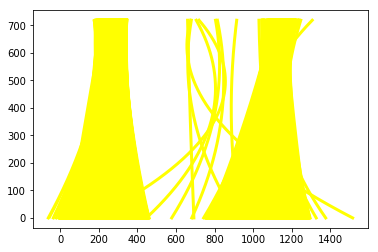

In [113]:
# Creating an object for the pipeline
pipeline = PipeLine('./camera_cal/calibration*.jpg')

clip1 = VideoFileClip(input_video)

white_clip = clip1.fl_image(pipeline)

%time white_clip.write_videofile(output_video, audio=False)